### prepair modules and bases settings

In [216]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix,  classification_report, log_loss
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
from scipy.stats import norm
import scipy.io
import re
import itertools

import os
from os.path import join
import contextlib
from copy import deepcopy
import imp 
import time 
import sys

In [217]:
# load local functions
import stim_io
import stim_io_plotting
import vtc

In [218]:
# plotting bases settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial',
                                   "Helvetica"]
plt.rcParams['figure.dpi']= 150
sns.set_style('white')


import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## General settings

In [219]:
pp = '2'
input_dir = '/media/jorvhar/Data1/MRIData/timing data/data/'

tr = 1.8
volumes = 235
nr_runs=12

In [220]:
# settings
mat = scipy.io.loadmat(join(input_dir,'{}/{}_settings_tonotopy.mat'.format(pp, pp)))
all_freqs = mat['cfg']['freq_array'][0][0][0,:]

# must match the tonotopy settings
tunsteps       = 10
freqstep       = 1
subsample      = np.arange(0,len(all_freqs), freqstep)
mustep         = np.diff(all_freqs[subsample])
muarray_bins   = all_freqs
muarray        = all_freqs[subsample]

# tuning sizes
fwhm           = np.linspace(1,(8), tunsteps)
octgrid        = fwhm / (2*np.sqrt(2*np.log(2)))
sigmagrid      = 2**octgrid

# set range of tunings and sharpnesses
pref_range  = muarray                # match t
sharp_range_fwhm = fwhm
sharp_range = octgrid                # check if correct, fwhm or sigma of gaussian?



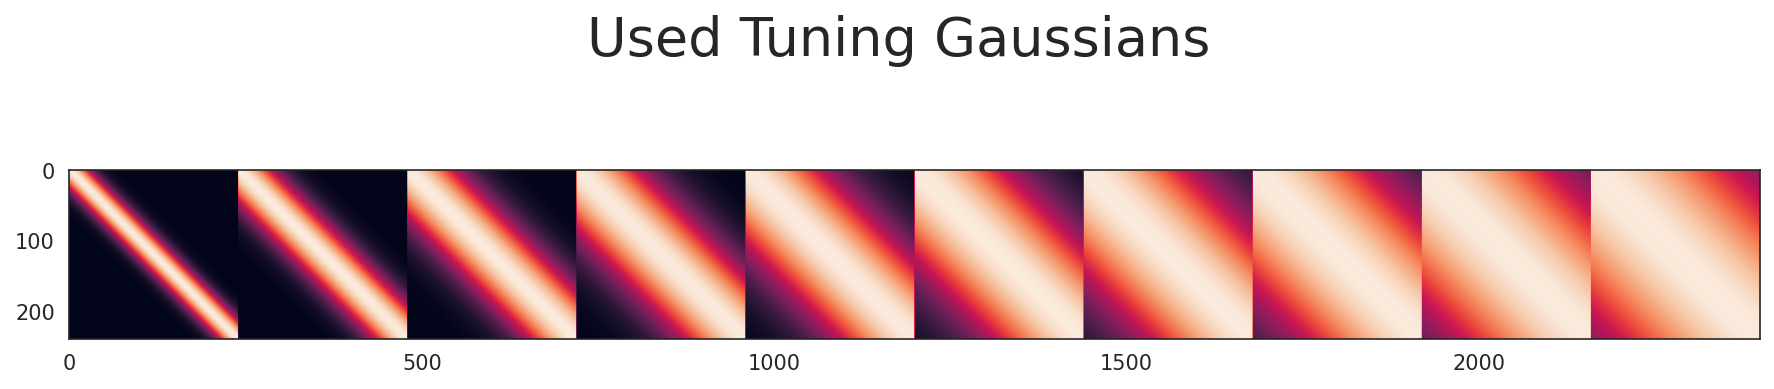

In [221]:
ax, fig = stim_io_plotting.freqs_plot(pref_range, sharp_range)

## 1. Load the data
### a. stimuli data

In [134]:
puls_df = stim_io.pulses_load(pp, input_dir, 12)
volumes_df = stim_io.volumes_load(puls_df, tr, volumes, nr_runs=12)

mat, stimuli = stim_io.data_load(pp, join(input_dir, pp))
stim_df = stim_io.stims_load(puls_df, volumes_df, mat, stimuli)

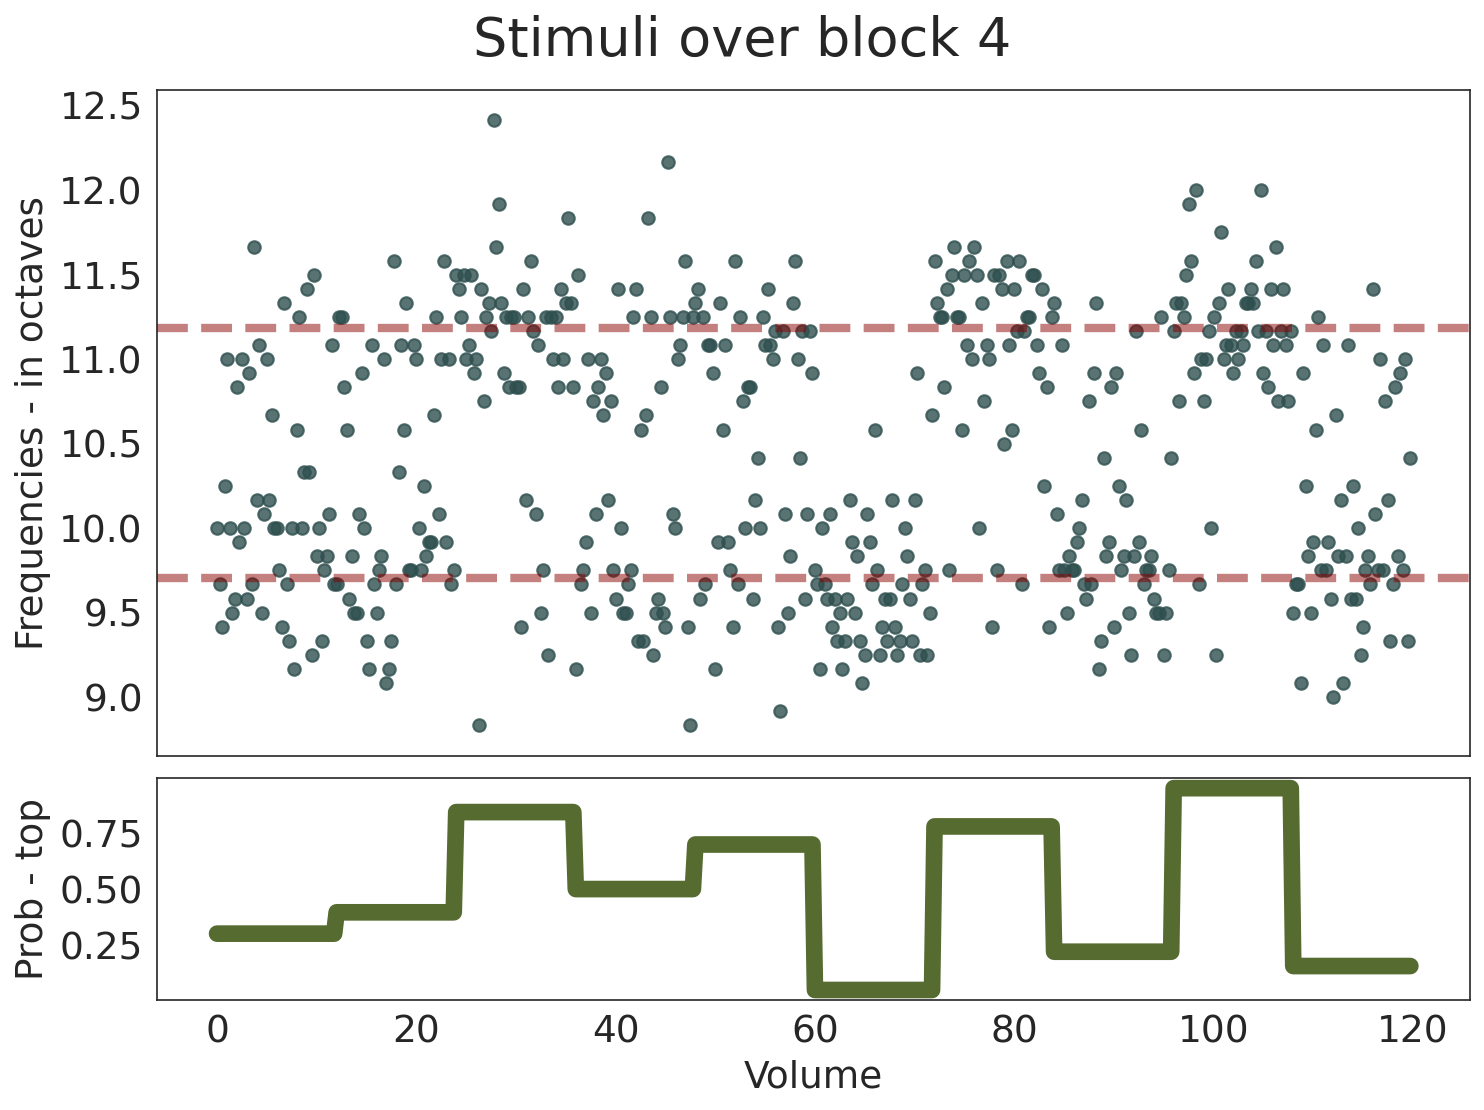

In [135]:
ax, fig = stim_io_plotting.data_plot(mat, stimuli, blocknr=4, octvspace=True)

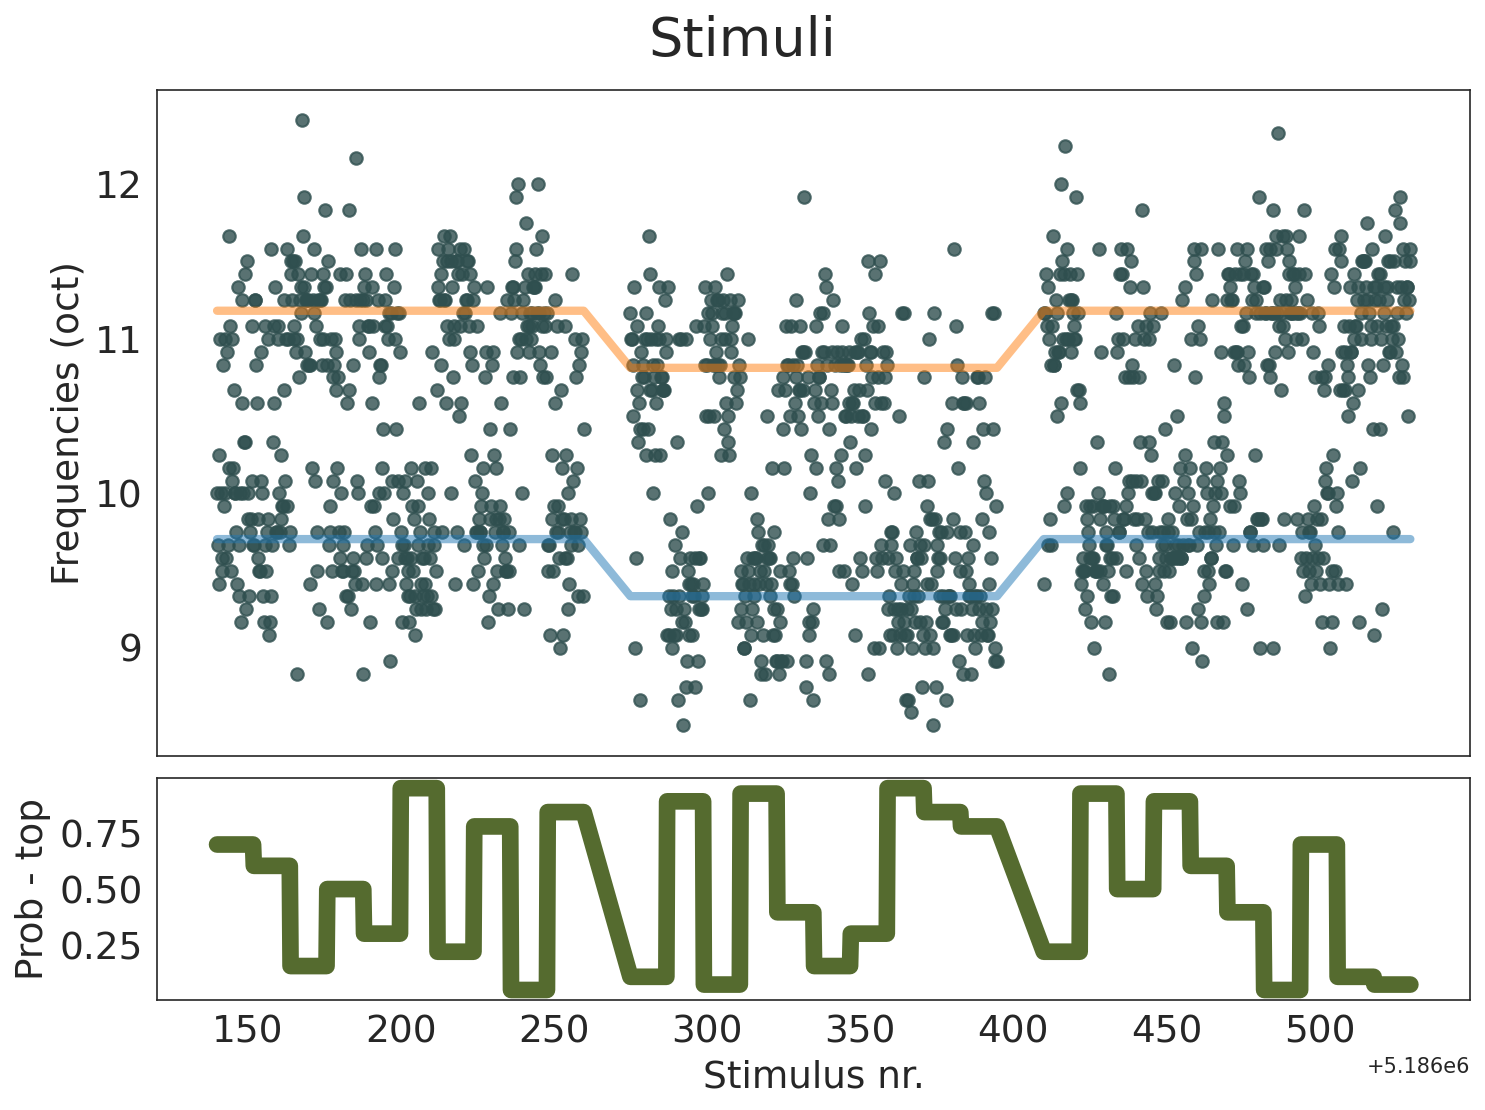

In [136]:
df = stim_df[stim_df['run'] == 2]
ax, fig = stim_io_plotting.stim_plot(df)

### b. add DREX data

In [138]:
stim_io.stims_export_mat(pp, input_dir, stim_df, pref_range)
stim_io.run_drex(pp, input_dir) # only have to do this once
stim_df = stim_io.stims_add_drex(pp, input_dir, stim_df)

<AxesSubplot:>

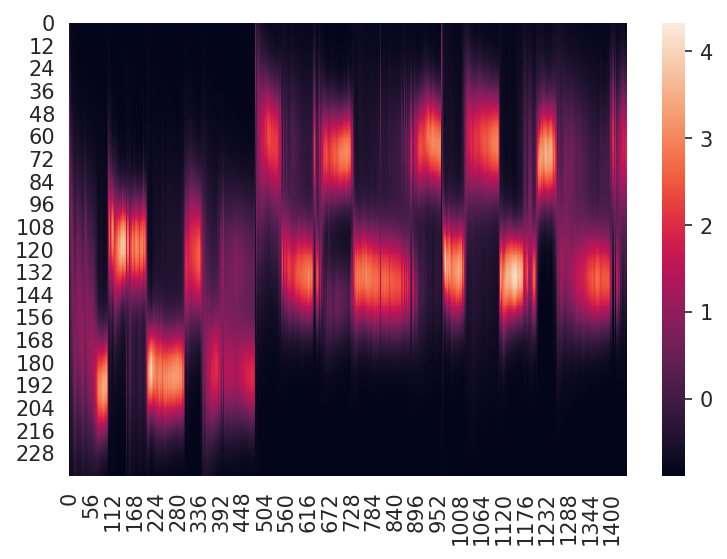

In [139]:
# quick senity check
run = 5
predprobz = stim_df[stim_df['run'] == run].filter(regex='pred_prob[_0-9.]+').to_numpy()

# z-score 
#  note: do we want to z-score the regressors over all voxels, otherwise we boost oudside range areas more
predprobz = (predprobz - predprobz.mean()) / predprobz.std()
#predprobz = (predprobz - predprobz.mean(axis=0)) / predprobz.std(axis=0) # dont do this

sns.heatmap( predprobz.transpose() )

### c. add adaptation data

In [140]:
import Adaptation.longtrace_adaptation as longtrace_adaptation
x_decay, y_decay = longtrace_adaptation.double_exp_decay_func(0.1399, 0.85, 0.0345, 6.82, [1, 10], 1)

activations, adaptations, adapted_activations, n_back_adaptations = stim_io.run_adaptation(stim_df, 
                                                                                           pref_range, 
                                                                                           sharp_range, 
                                                                                           y_decay)
stim_df = stim_io.stims_add_adaptation(stim_df, 
                                       pref_range, 
                                       sharp_range, 
                                       activations, 
                                       1-adaptations,       # take 1-adaptation to make filling with 0s possible
                                       adapted_activations)

# cleanup collumns
del activations, adaptations, adapted_activations, n_back_adaptations

<AxesSubplot:>

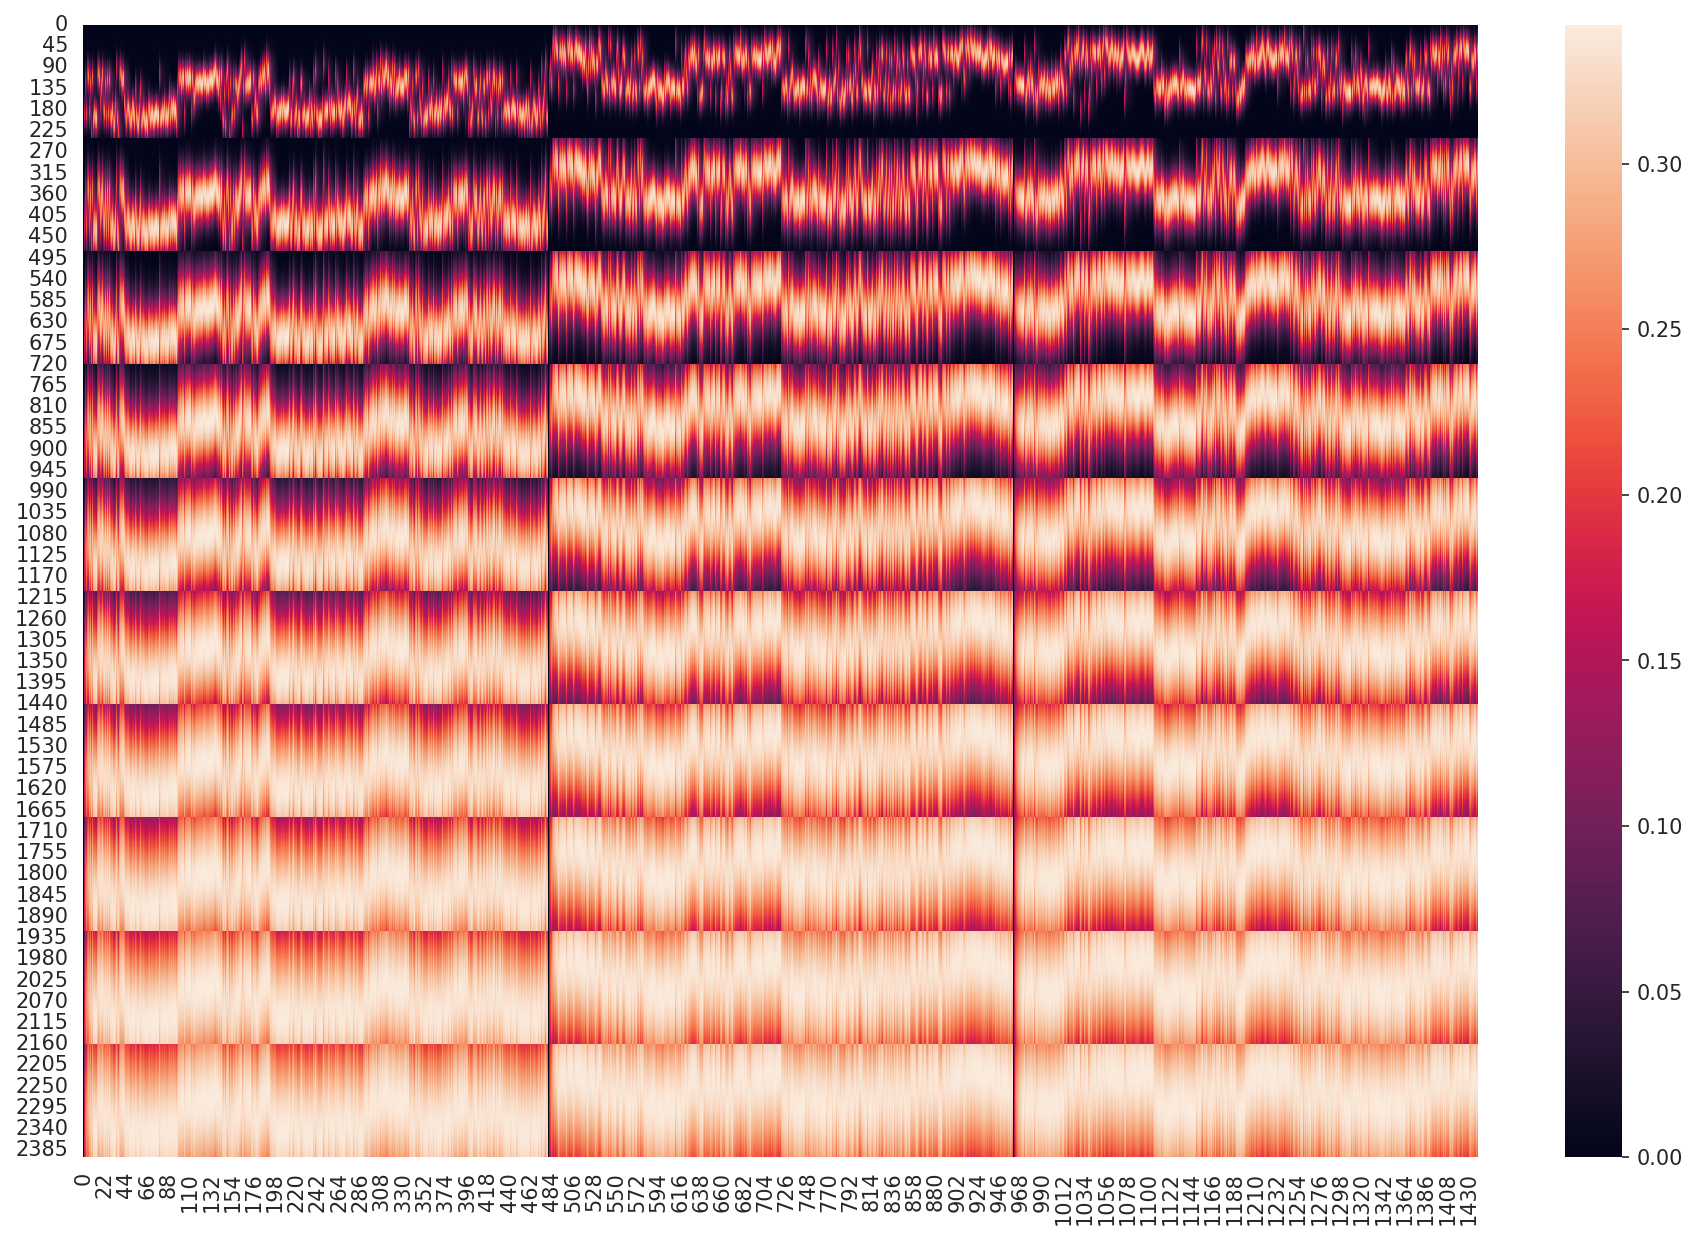

In [141]:
# quick senity check
run = 5
activs = stim_df[stim_df['run'] == run].filter(regex='adapt_[_0-9.]+').to_numpy()

fig, ax = plt.subplots(1,1, figsize=(15,10))

# z-score 
#  note: do we want to z-score the regressors over all voxels, otherwise we boost oudside range areas more
#activs = (activs - activs.mean()) / activs.std()
#predprobz = (predprobz - predprobz.mean(axis=0)) / predprobz.std(axis=0) # dont do this

sns.heatmap( activs.transpose() )

<AxesSubplot:>

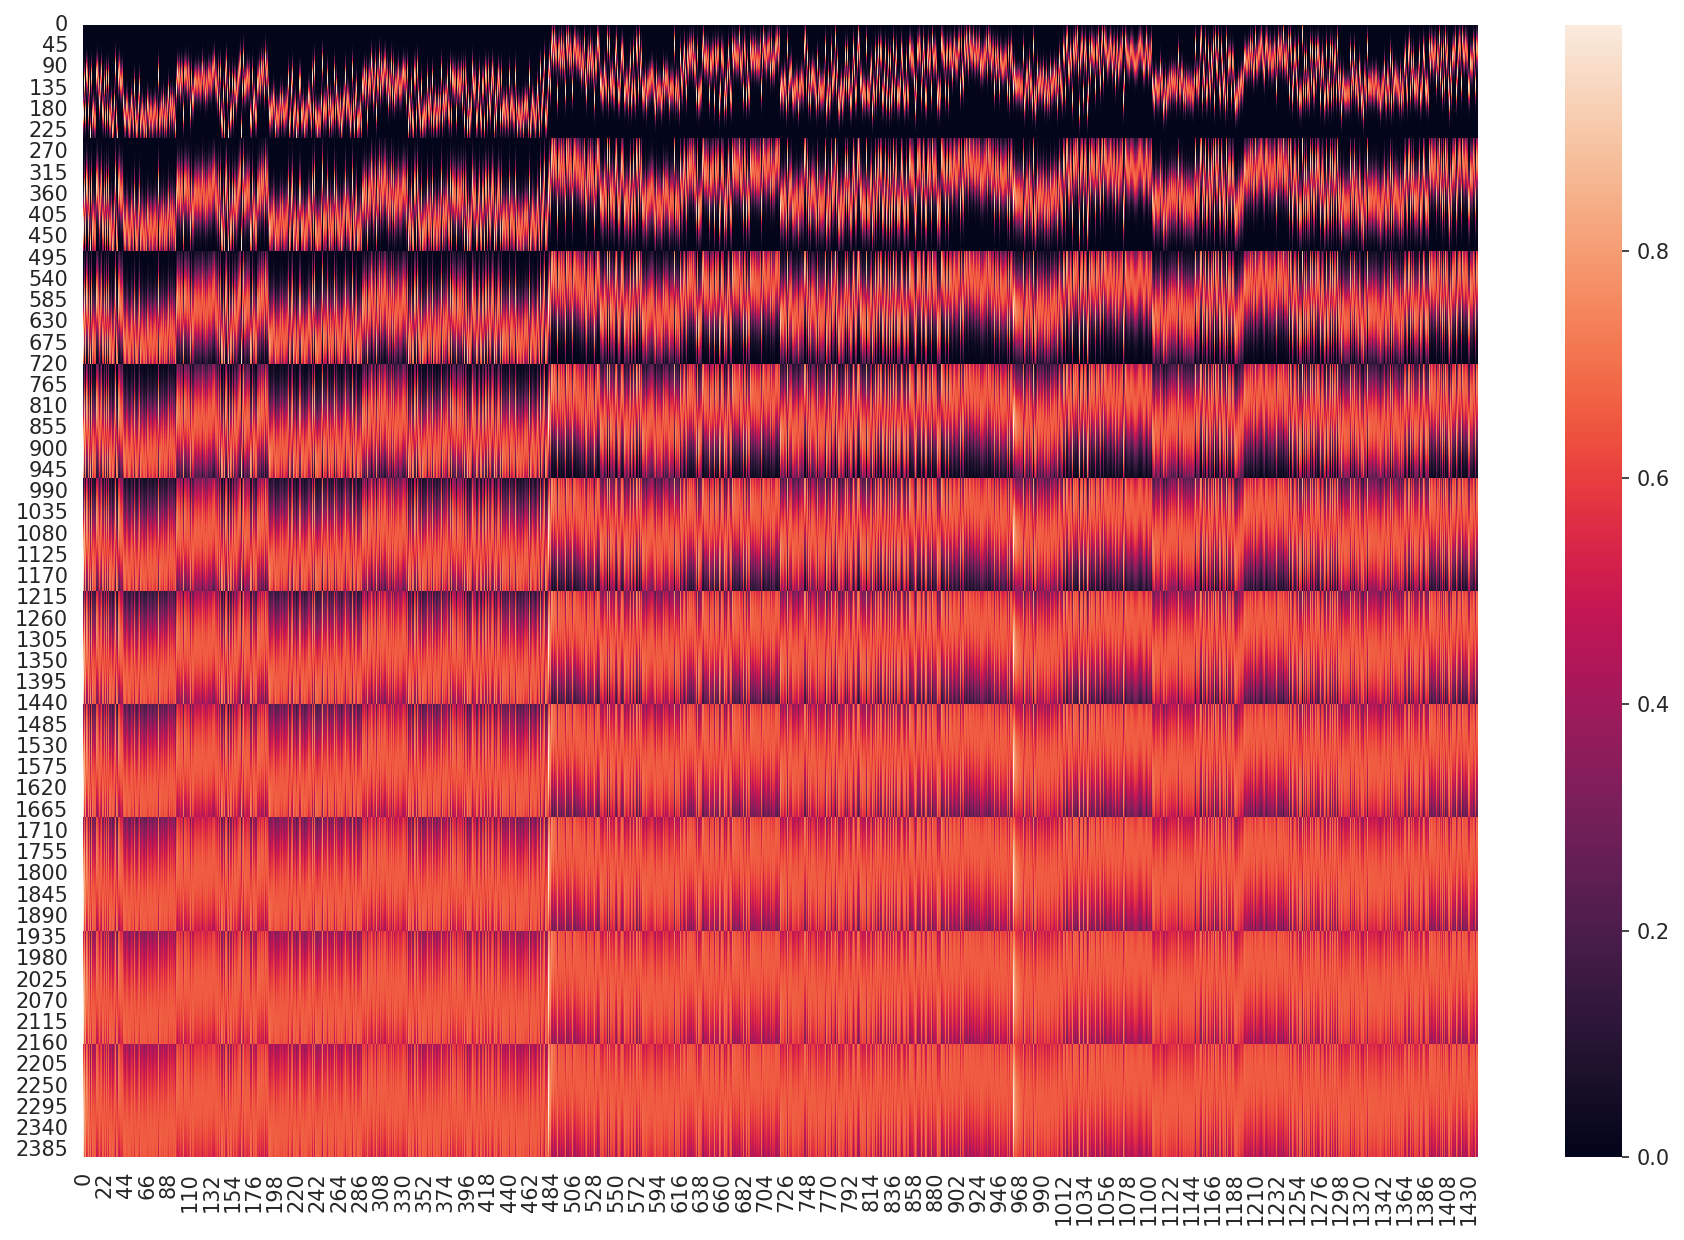

In [142]:
# quick senity check
run = 5
activs = stim_df[stim_df['run'] == run].filter(regex='activ_[_0-9.]+').to_numpy()

fig, ax = plt.subplots(1,1, figsize=(15,10))

# z-score 
#  note: do we want to z-score the regressors over all voxels, otherwise we boost oudside range areas more
#activs = (activs - activs.mean()) / activs.std()
#predprobz = (predprobz - predprobz.mean(axis=0)) / predprobz.std(axis=0) # dont do this

sns.heatmap( activs.transpose() )

## 2. TR domain transfer

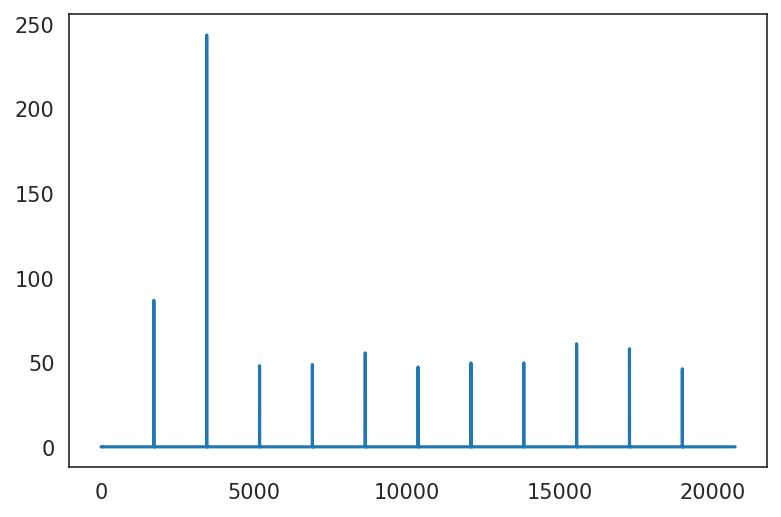

In [143]:
# main function for adding timesteps (inbetween runs, / blocks)
stim_df = stim_io.stims_add_temporal_pad(stim_df, volumes_df)

# sanity check timing diffs
plt.plot(stim_df['timing'].diff())

In [144]:
# load cononical hrf
hrf = scipy.io.loadmat('/media/jorvhar/Data1/MRIData/timing data/hrf.mat')
newhrf = stim_io.con_hrf_stimdomain(hrf, stim_df, plotres=False)

# convolve stim_df with hrf (the regressors)
stim_df = stim_io.stims_convolve_hrf(stim_df, newhrf)

In [145]:
# to get dataframe in tr space, simply 
# then, when we want to do the FIR, we can do this groupby sum approach, and take the non-convolved, and shift() some steps
  #tr_df = stim_df.groupby(['volume_abs']).sum()
    
tr_df = stim_io.stims_to_tr(stim_df, volumes_df, downsample_unconv=False)

In [146]:
print(f'Prefrange: \n {np.round(pref_range,4)}\n\nSharprange: \n {np.round(sharp_range,4)}')

p = pref_range[30]
t = sharp_range[5]

stim_io.get_tw_collumns(tr_df, p, t, convolved=True)

Prefrange: 
 [ 7.6439  7.6644  7.6849  7.7054  7.726   7.7465  7.767   7.7876  7.8081
  7.8286  7.8492  7.8697  7.8902  7.9108  7.9313  7.9518  7.9724  7.9929
  8.0134  8.0339  8.0545  8.075   8.0955  8.1161  8.1366  8.1571  8.1777
  8.1982  8.2187  8.2393  8.2598  8.2803  8.3008  8.3214  8.3419  8.3624
  8.383   8.4035  8.424   8.4446  8.4651  8.4856  8.5062  8.5267  8.5472
  8.5677  8.5883  8.6088  8.6293  8.6499  8.6704  8.6909  8.7115  8.732
  8.7525  8.7731  8.7936  8.8141  8.8346  8.8552  8.8757  8.8962  8.9168
  8.9373  8.9578  8.9784  8.9989  9.0194  9.04    9.0605  9.081   9.1016
  9.1221  9.1426  9.1631  9.1837  9.2042  9.2247  9.2453  9.2658  9.2863
  9.3069  9.3274  9.3479  9.3685  9.389   9.4095  9.43    9.4506  9.4711
  9.4916  9.5122  9.5327  9.5532  9.5738  9.5943  9.6148  9.6354  9.6559
  9.6764  9.6969  9.7175  9.738   9.7585  9.7791  9.7996  9.8201  9.8407
  9.8612  9.8817  9.9023  9.9228  9.9433  9.9639  9.9844 10.0049 10.0254
 10.046  10.0665 10.087  10.1076 10.128

['pred_prob_8.260_convolved',
 'raw_acti_8.260_2.076_convolved',
 'raw_adapt_8.260_2.076_convolved',
 'adapt_activ_8.260_2.076_convolved',
 'surprisal_convolved',
 'onoff_convolved']

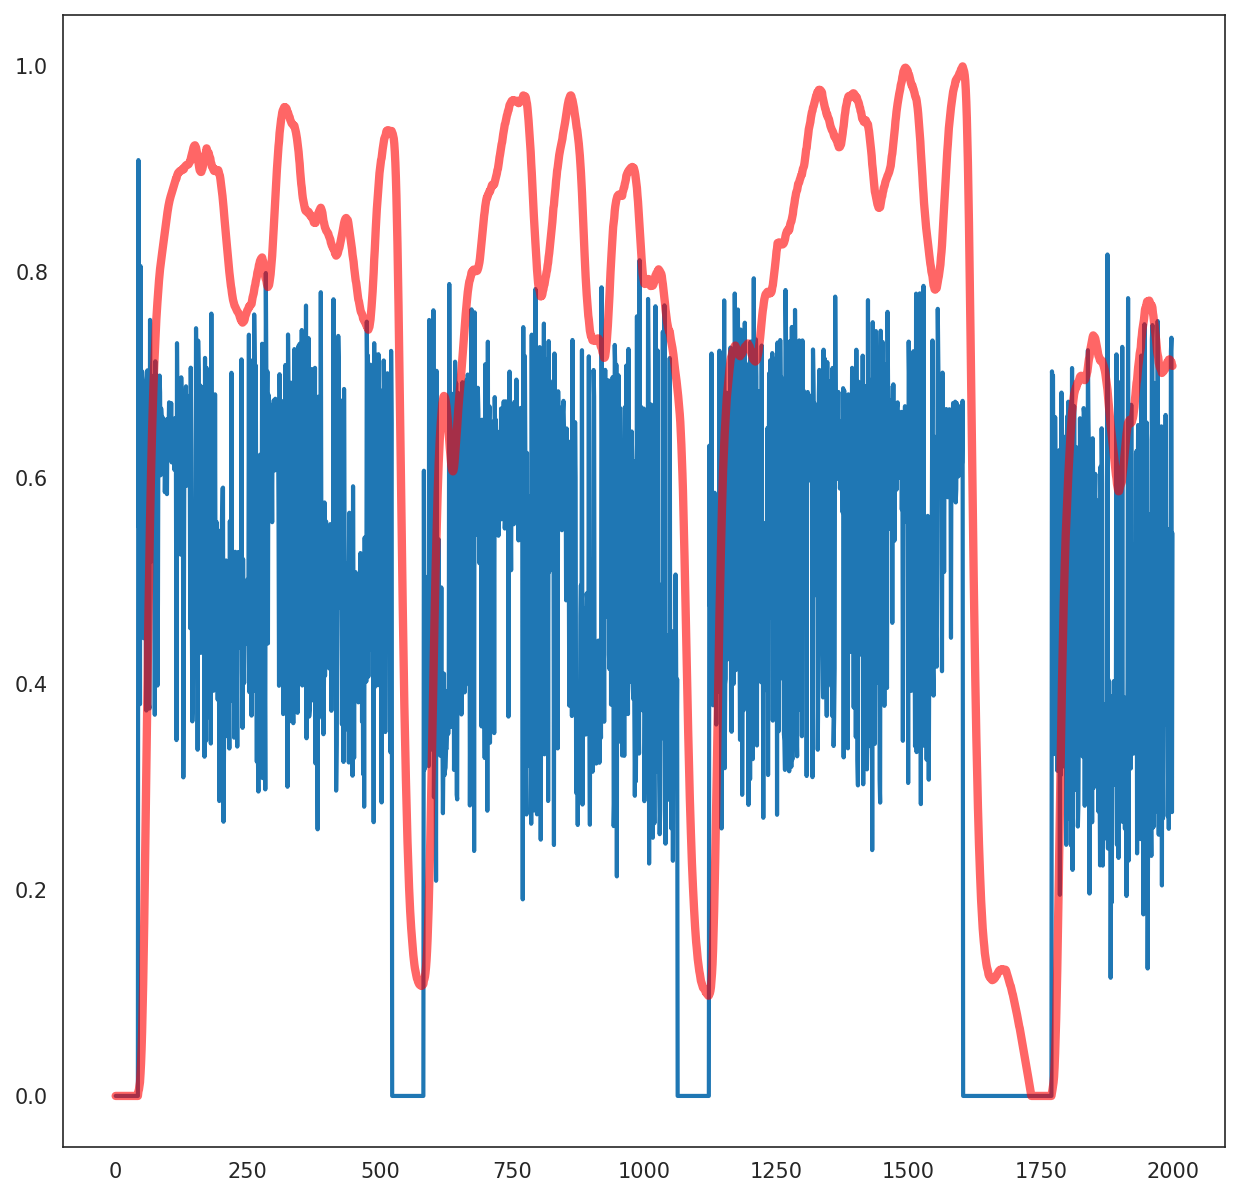

In [147]:
# check if worked
start = 0
end = 2000
ax, fig = plt.subplots(1, 1, figsize=(10,10))
plt.plot(stim_df[f'adapt_activ_{p:.3f}_{t:.3f}'][start:end], lw=2)
plt.plot(stim_io.normalize(stim_df[f'adapt_activ_{p:.3f}_{t:.3f}_convolved'][start:end]),color='r', alpha=0.6, lw=4)

In [148]:
stim_df[stim_df['frequencies'].notnull()]

frequencies  frequencies_oct        timing  closest_volume_rel  \
43      574.700569         9.166667  5.185621e+06                   5   
44     1149.401137        10.166667  5.185622e+06                   5   
45      683.438005         9.416667  5.185622e+06                   5   
46     1722.155858        10.750000  5.185622e+06                   5   
47      383.566612         8.583333  5.185622e+06                   5   
...            ...              ...           ...                 ...   
20606   812.749339         9.666667  5.191556e+06                 216   
20607  1366.876011        10.416667  5.191556e+06                 216   
20608   483.263648         8.916667  5.191556e+06                 217   
20609   767.133223         9.583333  5.191557e+06                 217   
20610   683.438005         9.416667  5.191557e+06                 217   

       closest_volume_abs  volume_rel  volume_abs   run  block  segment  ...  \
43                      5           5           5   1.0    1.0      1.0  ...   
44                      5           6           6   1.0    1.0      1.0  ...   
45                      5           6           6   1.0    1.0      1.0  ...   
46                      5           6           6   1.0    1.0      1.0  ...   
47                      5           6           6   1.0    1.0      1.0  ...   
...                   ...         ...         ...   ...    ...      ...  ...   
20606                2801         217        2802  12.0   36.0     10.0  ...   
20607                2801         217        2802  12.0   36.0     10.0  ...   
20608                2802         217        2802  12.0   36.0     10.0  ...   
20609                2802         217        2802  12.0   36.0     10.0  ...   
20610                2802         217        2802  12.0   36.0     10.0  ...   

       adapt_activ_12.407_3.397_convolved  adapt_activ_12.428_3.397_convolved  \
43                               0.048386                            0.048107   
44                               0.093768                            0.093363   
45                               0.133134                            0.132534   
46                               0.209599                            0.208782   
47                               0.294347                            0.293071   
...                                   ...                                 ...   
20606                           13.655034                           13.611478   
20607                           13.656214                           13.612670   
20608                           13.650505                           13.606938   
20609                           13.636176                           13.592531   
20610                           13.619499                           13.575764   

       adapt_activ_12.448_3.397_convolved  adapt_activ_12.469_3.397_convolved  \
43                               0.047828                            0.047549   
44                               0.092956                            0.092548   
45                               0.131932                            0.131329   
46                               0.207961                            0.207137   
47                               0.291790                            0.290505   
...                                   ...                                 ...   
20606                           13.567640                           13.523521   
20607                           13.568844                           13.524737   
20608                           13.563090                           13.518961   
20609                           13.548606                           13.504401   
20610                           13.531749                           13.487455   

       adapt_activ_12.489_3.397_convolved  adapt_activ_12.510_3.397_convolved  \
43                               0.047270                            0.046990   
44                               0.092139                    

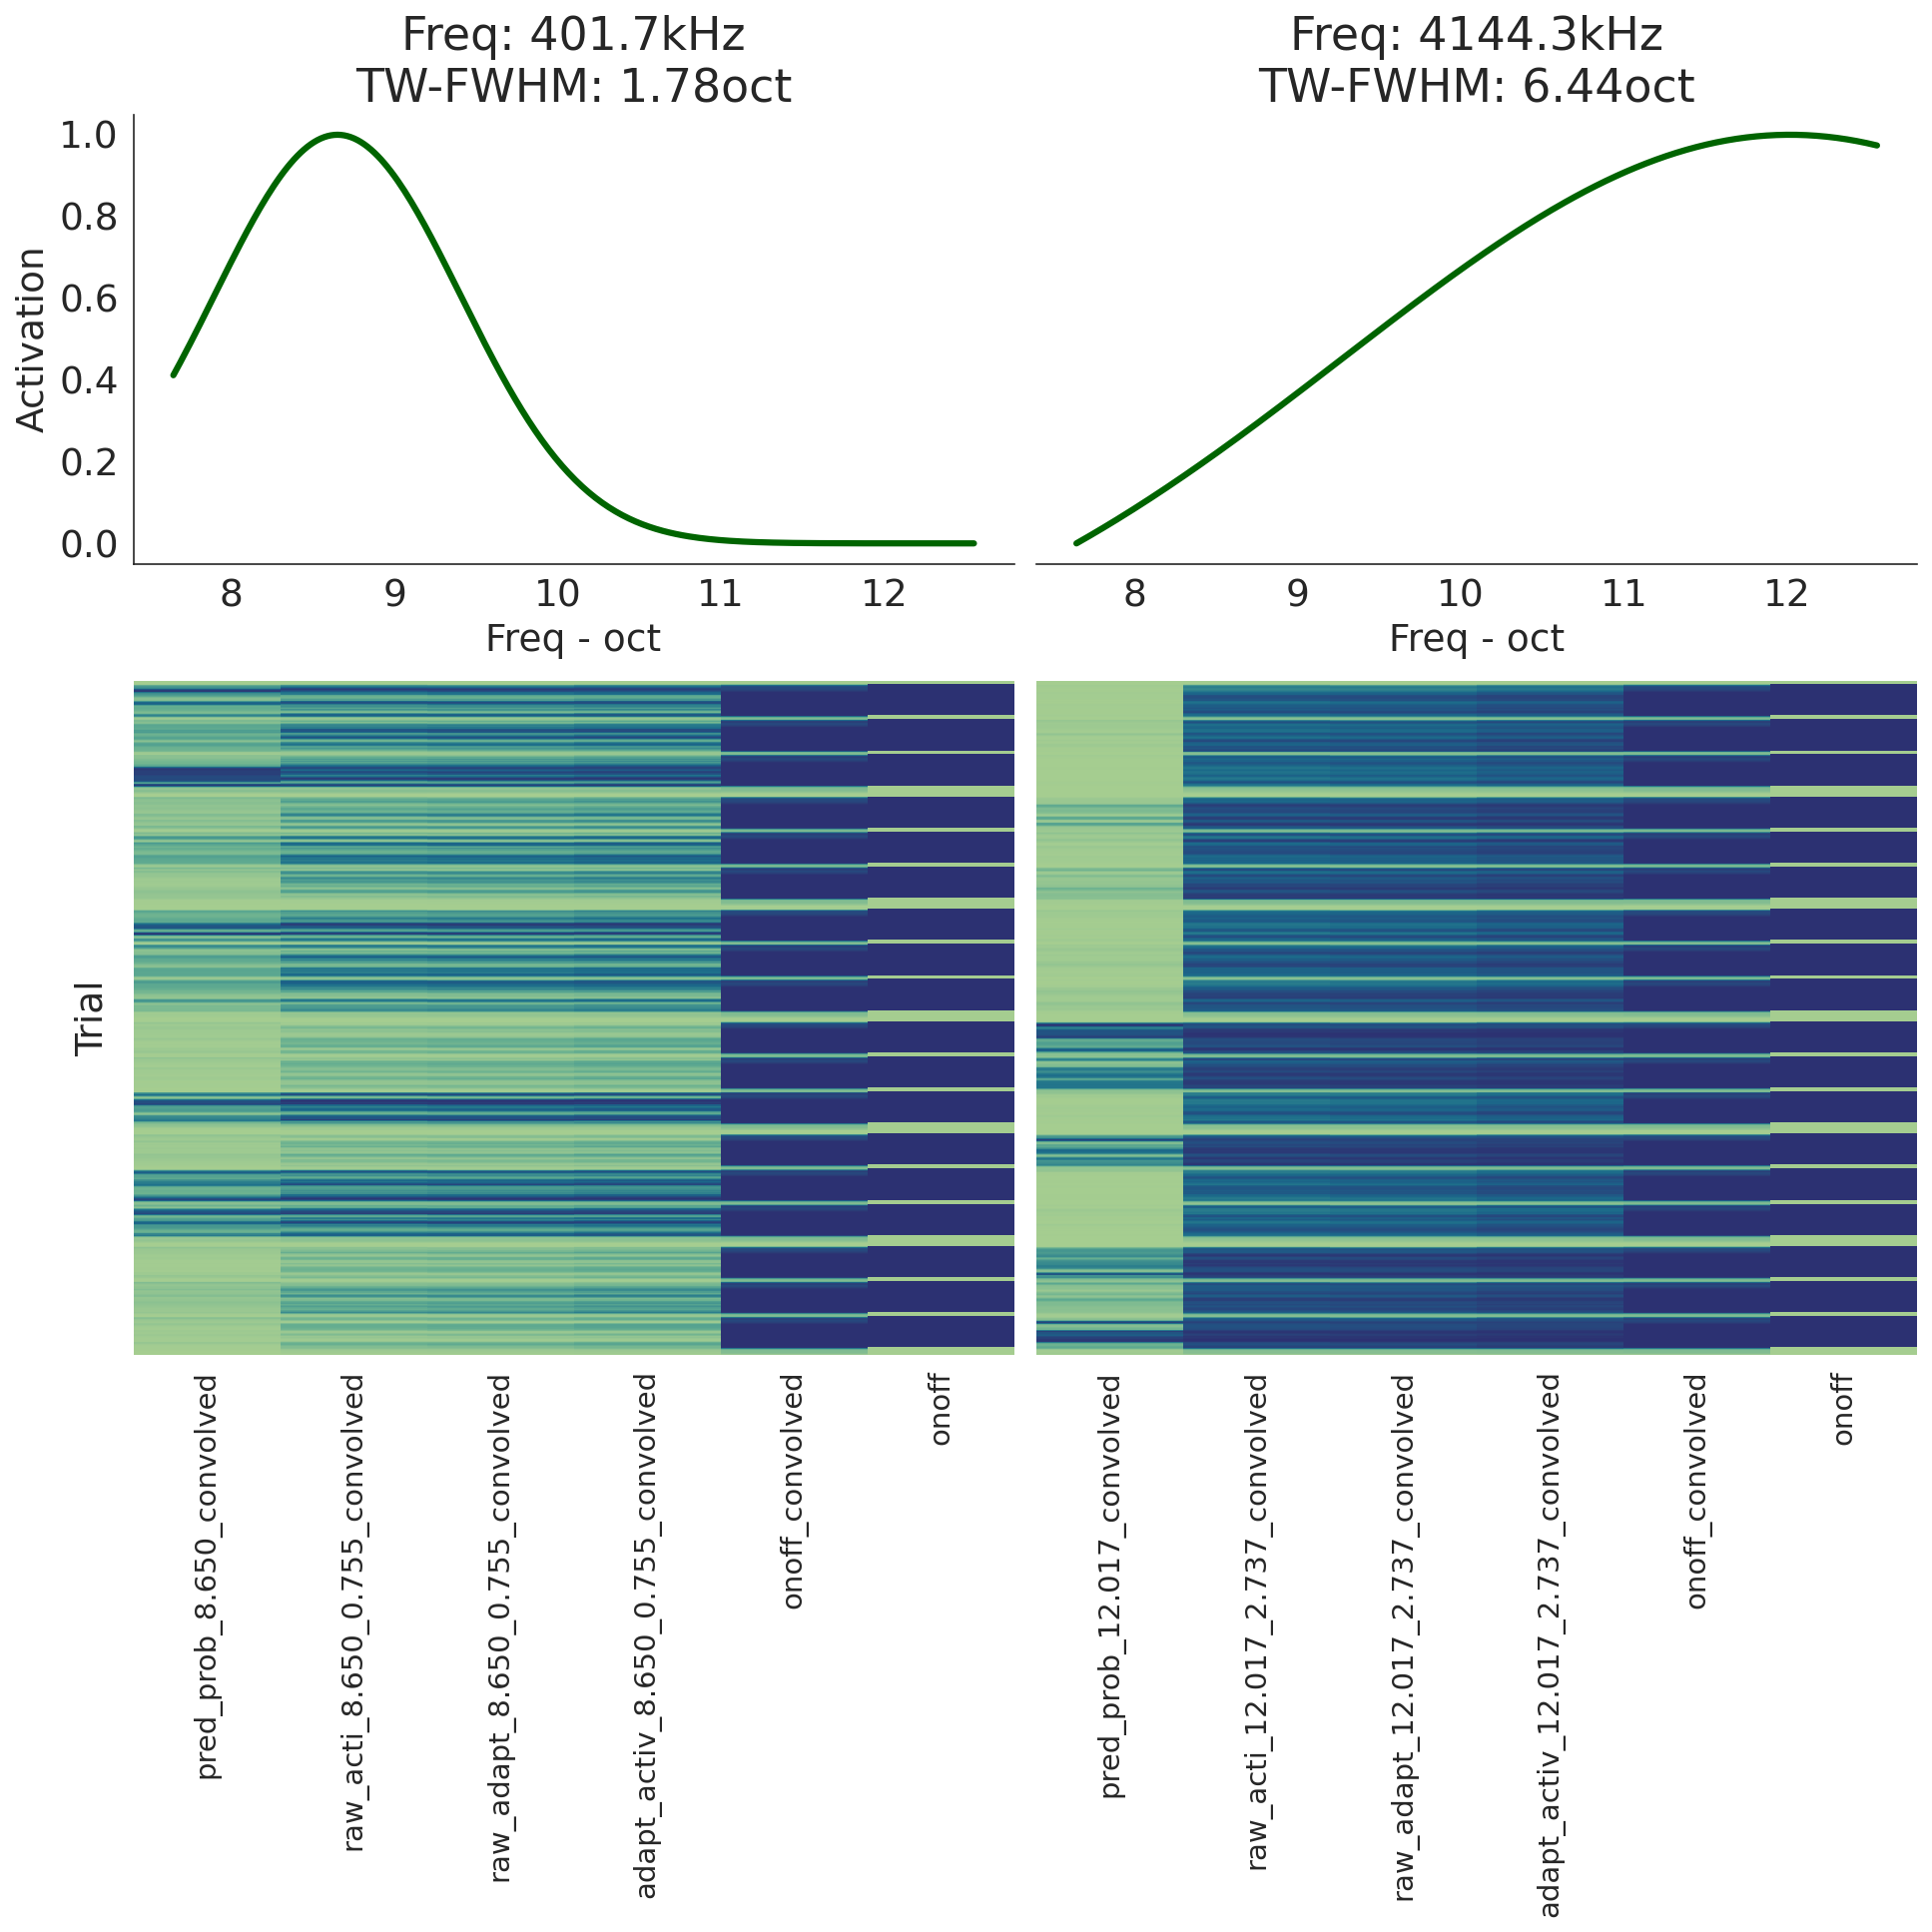

In [149]:
pref1 = 8.6499
pref2 = 12.0169

tw1 = 0.755
tw2 = 2.7367

ax, fig = stim_io_plotting.plot_design_mat(tr_df, all_freqs, pref1, tw1, pref2, tw2, runs=np.arange(1,7,1))

In [198]:
stim_df = stim_df[stim_df['run'] != 10]

## 2. Set up regresiion model
Options:

In [199]:
## OVERALL OPTIONS ##
save_predict = True           # save y_pred-y
score_of_interest = 'score'

SD_lim = 3                    # remove y x sd higher then mean
remove_outliers = False       # if false dont remove sd outliers 

z_score_x = True              
z_score_y = True              
z_score_scope = 2             # 1:over all, 2:within run, 3:within block

meanormedian = 'mean'         # mean makes varpart linear 

## OPTIONS ##
ppz = [1,2]
n_splitsz = [6,               # 12 runs > 10:2cross, 6 fold
             6]               # splits used per pp (for variable length option) 

# all 3 models
models = ['base',
          'adaptation',
          'prediction',
          'base_U_adaptation',
          'base_U_prediction',
          'adaptation_U_prediction',
          'base_U_adaptation_U_prediction']
# if we want to use 2models: 
models=['base_U_adaptation', 'prediction', 'base_U_adaptation_U_prediction']

## REGRESSORS IN MODELS ##
model_regressors = {'base':       ['raw_acti', 'onoff'], 
                    'adaptation': ['raw_adapt' ],      # adaptation
                    'prediction': ['pred_prob',   # voxelwise prior liklihood
                                   'surprisal']   # global prior surprise
                   } 
# if we want to add adapted activation
# model_regressors['adaptation'] += ['adapt_activ']

# set combination of regressors
model_regressors.update({'base_U_adaptation':             model_regressors['base']+
                                                          model_regressors['adaptation'],
                        'base_U_prediction':              model_regressors['base']+
                                                          model_regressors['prediction'], 
                        'adaptation_U_prediction':        model_regressors['adaptation']+
                                                          model_regressors['prediction'], 
                        'base_U_adaptation_U_prediction': model_regressors['base']+
                                                          model_regressors['adaptation']+
                                                          model_regressors['prediction']})
y_var = 'voxeltimecourse'

### loading input data

In [208]:
zs=lambda x: (x-x.mean(0)) /x.std(0)
corr_column= lambda a,b: (zs(a)*zs(b)).mean(0)
def zs_prior(x, prior_entr):
    return((prior_entr-x.mean(0)) /x.std(0))

def train_test_splits(df, n_splits, shuffle=True, random_state=123, group='run'):
    """ Main function for getting an array of train test splits
    
    input: df        : pandas dataframe, to obtain 'group' from
           n_splits  : number of train/test splits (k-folds)
           shuffle   : (default true) whether to shuffle KFolds
           random_state : (default 123) the random seed to use
           group     : (default 'run') the group to use for splitting
    
    returns: training indexes : [n_splits * groups in training]
             testing_indexes  : [n_splits * groups in testing]"""

    # use sklearn tool for getting kfolds
    kf = KFold(n_splits=n_splits, 
               shuffle=True,
               random_state=123)

    # get runs
    runz = df['run'].unique()

    # save empty list for train and test texts
    train_indexes = np.empty((0, int(len(runz)-len(runz)/n_splits)), int)
    test_indexes = np.empty((0, int(len(runz)/n_splits)), int)

    # loop for text in folds
    for train_index, test_index in kf.split(runz):
        train_indexes = np.append(train_indexes, 
                                  np.array([runz[train_index]]), 
                                  axis=0)
        test_indexes = np.append(test_indexes,
                                 np.array([runz[test_index]]),
                                 axis=0)
        
    # return train and test indexes
    return(train_indexes, test_indexes)
    
    
def model_fit(model, X_train,X_test,y_train,y_test, save_predict=False):
    """take the linear model, the train/test data and do scoring
    input:  model:    input model type
            X_train:  regressor input train data
            X_test:   regressor input test data
            y_train:  target train data
            y_test:   target test data
            save_predict:   save individual trail-by-trail predictions
    output: return scores dictionary
    """
    scores = {}
    
    # fit model, get y_pred, model proba and nullmodel proba
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # get model score, classification report, confustion matrix and coefs/intercepts
    scores['score'] = np.array([model.score(X_test, y_test)]) # place in array to make chunking easier
    scores['raw_scores'] = r2_score(y_test, y_pred, multioutput='raw_values')
    scores['coefs'] = model.coef_[:]
    scores['intercepts'] = model.intercept_
    scores['correlation'] = corr_column(y_test, y_pred)
    
    # save prediction scores if flagged
    if save_predict:
        scores['predict'] = {'y_pred': y_pred, 'y': y_test}
    
    # return cross validated scores
    return(scores)


def non_cv_fit(model, X, y, save_predict=False):
    """take the linear model, the train/test data and do scoring
    input:  model:    input model type
            X:        regressors
            y:        target var
            save_predict:   save individual trail-by-trail predictions
    output: return scores dictionary
    """
    scores = {}
    
    # fit model, get y_pred, model proba and nullmodel proba
    model.fit(X, y)
    y_pred = model.predict(X)
    #scores['modelproba'] = model.predict_proba(X)
    #scores['nullproba'] = pred_proba_null(y)
    
    # get model score, classification report, confustion matrix and coefs/intercepts
    scores['score'] = model.score(X, y)
    scores['raw_scores'] = r2_score(y, y_pred, multioutput='raw_values')
    #scores['conf_mat'] = (confusion_matrix(y, y_pred).T / confusion_matrix(y, y_pred).sum(axis=1)).T
    scores['coefs'] = model.coef_[:]
    scores['intercepts'] = model.intercept_
    scores['correlation'] = corr_column(y, y_pred)
    
    # save prediction scores if flagged
    if save_predict:
        scores['predict'] = {'y_pred': y_pred, 'y': y}
    
    # return scores    
    return(scores)


def extract_sublist(lst, prefixes):
    return [item for item in lst for prefix in prefixes if re.match(f"^{prefix}", item)]

### mask and vmp file loading

In [164]:
import bvbabel

mridat_dir = '/media/jorvhar/Data1/MRIData/PreProc'
vtc_dir = '/media/jorvhar/New Volume1/vtcs' # adviced to put vtc's on a (nvme) ssd while running analyses
pp_dir = lambda pp, ses : f'S{pp:02d}_SES{ses}'
betas_dir = 'Betas'

# tonotopy and mask filenames
tonotopy_vmp = 'prf_permutations_for_S2.vmp'
mask_fn = 'brainmask.msk'

# chunking settings
chucksize = 50000   # msk[0].shape[0]
pp = 1
ses = 2

# fn lambda
fn = lambda pp, ses, run : f'S{pp:02d}_SES{ses}_run{run}_FMR_SCSTBL_3DMAS_THPGLMF7c_TOPUP.vtc'

# create full path
mskpath = join(mridat_dir, pp_dir(2,1), mask_fn)
vmppath = join(mridat_dir, pp_dir(pp,1), betas_dir, tonotopy_vmp)

# load full mask and convert to indeces
_, msk = bvbabel.msk.read_msk(mskpath)
msk = np.where(msk)
# devide the mask in chucks based on our chucksize
chunked_msk = vtc.chuck_msk(msk, chucksize)

# load vmp image
vmp_head, vmp_img = bvbabel.vmp.read_vmp(vmppath)

### reconstruction of image
(for testing)

y shape: (50000, 2585)	 run_nr shape: (2585,)


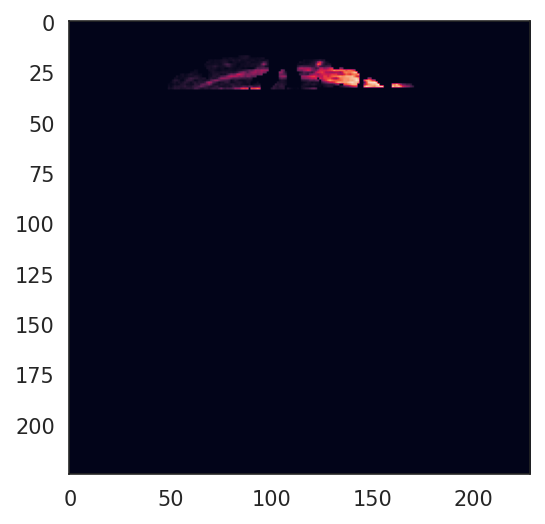

In [166]:
# get vtc filenames
runz = [1,2,3,4,5,6,7,8,9,11,12]
vtc_fns = [join(mridat_dir, pp_dir(pp,ses), fn(pp,ses,run)) for run in runz]

# load vtc chunks
y, run_nr = stim_io.load_vtc_chunk_runs(vtc_fns, chunked_msk[0])
print(f'y shape: {y.shape}\t run_nr shape: {run_nr.shape}')

# senity check to display a chunk
n_img = stim_io.reconstruct_vtc(y[:,run_nr==5], chunked_msk[0], 
                                vtc_for_header=vtc_fns[0]) # or None
plt.imshow(n_img[:,:,40,100])

## Doing the regressions
(testing for single tpref and tw - chunked regressions)

In [190]:
stim_df

frequencies  frequencies_oct        timing  closest_volume_rel  \
0              NaN              NaN  5.185610e+06                   0   
1              NaN              NaN  5.185611e+06                   0   
2              NaN              NaN  5.185611e+06                   0   
3              NaN              NaN  5.185611e+06                   0   
4              NaN              NaN  5.185611e+06                   0   
...            ...              ...           ...                 ...   
20731          NaN              NaN  5.191587e+06                 233   
20732          NaN              NaN  5.191587e+06                 233   
20733          NaN              NaN  5.191588e+06                 234   
20734          NaN              NaN  5.191588e+06                 234   
20735          NaN              NaN  5.191588e+06                 234   

       closest_volume_abs  volume_rel  volume_abs   run  block  segment  ...  \
0                       0           0           0   1.0    1.0      NaN  ...   
1                       0           0           0   1.0    1.0      NaN  ...   
2                       0           0           0   1.0    1.0      NaN  ...   
3                       0           0           0   1.0    1.0      NaN  ...   
4                       0           0           0   1.0    1.0      NaN  ...   
...                   ...         ...         ...   ...    ...      ...  ...   
20731                2818         234        2819  12.0   36.0      NaN  ...   
20732                2818         234        2819  12.0   36.0      NaN  ...   
20733                2819         234        2819  12.0   36.0      NaN  ...   
20734                2819         234        2819  12.0   36.0      NaN  ...   
20735                2819         234        2819  12.0   36.0      NaN  ...   

       adapt_activ_12.407_3.397_convolved  adapt_activ_12.428_3.397_convolved  \
0                                0.000000                            0.000000   
1                                0.000000                            0.000000   
2                                0.000000                            0.000000   
3                                0.000000                            0.000000   
4                                0.000000                            0.000000   
...                                   ...                                 ...   
20731                            0.345855                            0.344550   
20732                            0.307654                            0.306499   
20733                            0.267581                            0.266569   
20734                            0.234363                            0.233508   
20735                            0.202949                            0.202256   

       adapt_activ_12.448_3.397_convolved  adapt_activ_12.469_3.397_convolved  \
0                                0.000000                            0.000000   
1                                0.000000                            0.000000   
2                                0.000000                            0.000000   
3                                0.000000                            0.000000   
4                                0.000000                            0.000000   
...                                   ...                                 ...   
20731                            0.343239                            0.341921   
20732                            0.305338                            0.304171   
20733                            0.265551                            0.264528   
20734                            0.232647                            0.231782   
20735                            0.201558                            0.200856   

       adapt_activ_12.489_3.397_convolved  adapt_activ_12.510_3.397_convolved  \
0                                0.000000                            0.000000   
1                                0.000000                    

In [195]:
stim_df[stim_df['run'] == 10]

frequencies  frequencies_oct        timing  closest_volume_rel  \
15552          NaN              NaN  5.190188e+06                   0   
15553          NaN              NaN  5.190188e+06                   0   
15554          NaN              NaN  5.190189e+06                   0   
15555          NaN              NaN  5.190189e+06                   0   
15556          NaN              NaN  5.190189e+06                   0   
...            ...              ...           ...                 ...   
17275          NaN              NaN  5.190619e+06                 233   
17276          NaN              NaN  5.190619e+06                 233   
17277          NaN              NaN  5.190620e+06                 234   
17278          NaN              NaN  5.190620e+06                 234   
17279          NaN              NaN  5.190620e+06                 234   

       closest_volume_abs  volume_rel  volume_abs   run  block  segment  ...  \
15552                2115           0        2115  10.0   28.0      NaN  ...   
15553                2115           0        2115  10.0   28.0      NaN  ...   
15554                2115           0        2115  10.0   28.0      NaN  ...   
15555                2115           0        2115  10.0   28.0      NaN  ...   
15556                2115           0        2115  10.0   28.0      NaN  ...   
...                   ...         ...         ...   ...    ...      ...  ...   
17275                2348         234        2349  10.0   30.0      NaN  ...   
17276                2348         234        2349  10.0   30.0      NaN  ...   
17277                2349         234        2349  10.0   30.0      NaN  ...   
17278                2349         234        2349  10.0   30.0      NaN  ...   
17279                2349         234        2349  10.0   30.0      NaN  ...   

       adapt_activ_12.407_3.397_convolved  adapt_activ_12.428_3.397_convolved  \
15552                            0.189692                            0.189390   
15553                            0.139523                            0.139261   
15554                            0.092109                            0.091926   
15555                            0.047431                            0.047353   
15556                            0.000000                            0.000000   
...                                   ...                                 ...   
17275                            0.420984                            0.420342   
17276                            0.383330                            0.382835   
17277                            0.335389                            0.334972   
17278                            0.285165                            0.284782   
17279                            0.238873                            0.238577   

       adapt_activ_12.448_3.397_convolved  adapt_activ_12.469_3.397_convolved  \
15552                            0.189083                            0.188772   
15553                            0.138997                            0.138729   
15554                            0.091741                            0.091554   
15555                            0.047273                            0.047193   
15556                            0.000000                            0.000000   
...                                   ...                                 ...   
17275                            0.419691                            0.419031   
17276                            0.382331                            0.381819   
17277                            0.334548                            0.334116   
17278                            0.284392                            0.283995   
17279                            0.238275                            0.237967   

       adapt_activ_12.489_3.397_convolved  adapt_activ_12.510_3.397_convolved  \
15552                            0.188457                            0.188137   
15553                            0.138458                    

In [33]:
# quick settings
n_splits = 6  #6
tpref = 9.9228
tw = 0.755
convolved = True

# get vtc filenames and settings
runz = [1,2,3,4,5,6,7,8,9,10,11,12]
save_predict = False

# set modeltype
modeltype = LinearRegression() #can be LinearRegression (ols), Ridge(alpha=..), Lasso(alpha=..)  etc.
key_ai = ['raw_scores', 'coefs', 'intercepts', 'correlation'] # what keys to median and mean across folds


## --- DEFINING TEST TRAIN SPLIT ---

# get test train splits per run
train_matrix, test_matrix = train_test_splits(df, n_splits)


## --- BASED ON TUNING PREF AND TW LOAD DESIRED COLUMNS OUT OF DF ---

# load (all) xnames
col_names = stim_io.get_tw_collumns(tr_df, tpref, tw, convolved=convolved)

# load voxeltimecourse filenames
vtc_fns = [join(mridat_dir, pp_dir(pp,ses), fn(pp,ses,run)) for run in runz]

# predefine dictionaries for saving regression results
scores = {}


# --- LOOP OVER CHUCKS TO MANAGE MEMORY ---
for curchunk in range(len(chunked_msk)):
    
    # load vtc for chunk
    y, run_nr = stim_io.load_vtc_chunk_runs(vtc_fns, chunked_msk[curchunk])
    y = y.transpose() # transpose to make k-fold splits simpler

    
# --- LOOP OVER ALL MODELS FOR DOING SET THEORY --- 
    for model in models:

        # get X for this model 
        col_regressors = extract_sublist(col_names, model_regressors[model])
        X = tr_df[col_regressors].to_numpy()
        print(f'{model}:\n\t\t{extract_sublist(col_names, model_regressors[model])}\n')

        # (re)predefine dictionary for storing this models all folds
        nscore = {}
        
        
### --- RUN SCRIPT TO DO KFOLDED REGRESSION, AND PARSE OUTPUT IN MEANINGFULL WAY
        # get cross validated scores based on previously defined test/train splits
        for fold in range(len(train_matrix)):
            # save indexes for text number in array
            train_idx = np.argwhere(np.in1d(run_nr, train_matrix[fold])).flatten()
            test_idx = np.argwhere(np.in1d(run_nr, test_matrix[fold])).flatten()

            # select train and test sets for fold
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # do the regression
            nscore[fold+1] = model_fit(modeltype, 
                                       X_train,
                                       X_test,
                                       y_train,
                                       y_test,
                                       save_predict=save_predict)
            
        # check if we update previous chunk or initate dict using this one
        if model not in scores:
            scores[model] = nscore
        else:
            # combine all the folds into one dictionary - aditionally append chunks
            for fold in range(len(train_matrix)):
                scores[model][fold+1] = {key : np.concatenate((scores[model][fold+1][key], 
                                                               nscore[fold+1][key])) for key in nscore[fold+1]}
                
        # store median and mean across folds
        for k in key_ai:
            cv_scores = {'median':  np.median(np.array([scores[model][fold+1][k] for 
                                                        fold in range(len(train_matrix))]), axis=0),
                         'mean':   np.nanmean(np.array([scores[model][fold+1][k] for 
                                                        fold in range(len(train_matrix))]), axis=0)}
            scores[model][k] = cv_scores
            
            
### --- DO ANOTHER REGRESSION WITHOUT CROSS VALIDATION, TO VALIDATE RESULTS
        # get non-crossvalidated scores
        scores[model]['non-cv'] = non_cv_fit(modeltype, 
                                                X,
                                                y,
                                                save_predict=save_predict)

base:
		['raw_acti_9.923_0.755_convolved', 'onoff_convolved']

adaptation:
		['raw_adapt_9.923_0.755_convolved']

prediction:
		['pred_prob_9.923_convolved', 'surprisal_convolved']

base_U_adaptation:
		['raw_acti_9.923_0.755_convolved', 'raw_adapt_9.923_0.755_convolved', 'onoff_convolved']

base_U_prediction:
		['pred_prob_9.923_convolved', 'raw_acti_9.923_0.755_convolved', 'surprisal_convolved', 'onoff_convolved']

adaptation_U_prediction:
		['pred_prob_9.923_convolved', 'raw_adapt_9.923_0.755_convolved', 'surprisal_convolved']

base_U_adaptation_U_prediction:
		['pred_prob_9.923_convolved', 'raw_acti_9.923_0.755_convolved', 'raw_adapt_9.923_0.755_convolved', 'surprisal_convolved', 'onoff_convolved']

base:
		['raw_acti_9.923_0.755_convolved', 'onoff_convolved']

adaptation:
		['raw_adapt_9.923_0.755_convolved']

prediction:
		['pred_prob_9.923_convolved', 'surprisal_convolved']

base_U_adaptation:
		['raw_acti_9.923_0.755_convolved', 'raw_adapt_9.923_0.755_convolved', 'onoff_convolv

adaptation_U_prediction:
		['pred_prob_9.923_convolved', 'raw_adapt_9.923_0.755_convolved', 'surprisal_convolved']

base_U_adaptation_U_prediction:
		['pred_prob_9.923_convolved', 'raw_acti_9.923_0.755_convolved', 'raw_adapt_9.923_0.755_convolved', 'surprisal_convolved', 'onoff_convolved']

base:
		['raw_acti_9.923_0.755_convolved', 'onoff_convolved']

adaptation:
		['raw_adapt_9.923_0.755_convolved']

prediction:
		['pred_prob_9.923_convolved', 'surprisal_convolved']

base_U_adaptation:
		['raw_acti_9.923_0.755_convolved', 'raw_adapt_9.923_0.755_convolved', 'onoff_convolved']

base_U_prediction:
		['pred_prob_9.923_convolved', 'raw_acti_9.923_0.755_convolved', 'surprisal_convolved', 'onoff_convolved']

adaptation_U_prediction:
		['pred_prob_9.923_convolved', 'raw_adapt_9.923_0.755_convolved', 'surprisal_convolved']

base_U_adaptation_U_prediction:
		['pred_prob_9.923_convolved', 'raw_acti_9.923_0.755_convolved', 'raw_adapt_9.923_0.755_convolved', 'surprisal_convolved', 'onoff_convolve

## Full regression
- using tpref and tw from vmp file

In [209]:
st = time.time()


# quick settings
n_splits = 6  #6
convolved = True

# get vtc filenames and settings
runz = [1,2,3,4,5,6,7,8,9,11,12]
save_predict = False

# set modeltype
modeltype = LinearRegression() #can be LinearRegression (ols), Ridge(alpha=..), Lasso(alpha=..)  etc.
key_ai = ['raw_scores', 'coefs', 'intercepts', 'correlation'] # what keys to median and mean across folds


## --- DEFINING TEST TRAIN SPLIT ---

# get test train splits per run
train_matrix, test_matrix = train_test_splits(stim_df, n_splits)


## --- BASED ON TUNING PREF AND TW LOAD DESIRED COLUMNS OUT OF DF ---

# load tonotopy vmp
vmp_df = pd.DataFrame(vmp_img[msk])

## DELETE, AND PLACE LATER, SINCE COL_NAMES WILL DIFFER BASED ON GRIDLOOP
# # load (all) xnames
# col_names = stim_io.get_tw_collumns(tr_df, tpref, tw, convolved=convolved)

# load voxeltimecourse filenames
vtc_fns = [join(vtc_dir, fn(pp,ses,run)) for run in runz]

# predefine dictionaries for saving regression results
scores = {}


## --- LOOP OVER FULL GRID OF PREFS * TWS ---

# create grid and do full loop
for tpref, tw in itertools.product(pref_range, sharp_range):
    # TEMP FOR TIMING
    st_temp = time.time() #start timing

    # get grid position indexes for tuning pref and tw
    grid_idx = vmp_df.loc[np.isclose(vmp_df[0], tpref, rtol=1e-3) & 
                          np.isclose(vmp_df[1], tw, rtol=1e-3)].index
    
    # check if any boxels in gridposition
    if grid_idx.empty == False:
        
        # use these grid positions to get a chuck of the mask
        msk_chunk = [i[grid_idx] for i in msk]

        # load vtc for chunk
        y, run_nr = stim_io.load_vtc_chunk_runs(vtc_fns, msk_chunk)
        y = y.transpose() # transpose to make k-fold splits simpler

        # load xnames for this columns
        col_names = stim_io.get_tw_collumns(tr_df, tpref, tw, convolved=convolved)


# --- LOOP OVER ALL MODELS FOR DOING SET THEORY --- 
        for model in models:

            # get X for this model 
            col_regressors = extract_sublist(col_names, model_regressors[model])
            X = tr_df[col_regressors].to_numpy()
            #print(f'{model}:\n\t\t{extract_sublist(col_names, model_regressors[model])}\n')

            # (re)predefine dictionary for storing this models all folds
            nscore = {}
        
        
### --- RUN SCRIPT TO DO KFOLDED REGRESSION, AND PARSE OUTPUT IN MEANINGFULL WAY
            # get cross validated scores based on previously defined test/train splits
            for fold in range(len(train_matrix)):
                # save indexes for text number in array
                train_idx = np.argwhere(np.in1d(run_nr, train_matrix[fold])).flatten()
                test_idx = np.argwhere(np.in1d(run_nr, test_matrix[fold])).flatten()

                # select train and test sets for fold
                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]

                # do the regression
                nscore[fold+1] = model_fit(modeltype, 
                                           X_train,
                                           X_test,
                                           y_train,
                                           y_test,
                                           save_predict=save_predict)

            # check if we update previous chunk or initate dict using this one
            if model not in scores:
                scores[model] = nscore
            else:
                # combine all the folds into one dictionary - aditionally append chunks
                for fold in range(len(train_matrix)):
                    scores[model][fold+1] = {key : np.concatenate((scores[model][fold+1][key], 
                                                                   nscore[fold+1][key])) for key in nscore[fold+1]}


### --- DO ANOTHER REGRESSION WITHOUT CROSS VALIDATION, TO VALIDATE RESULTS ---
            # get non-crossvalidated scores
    # need fixing
            nscore_noncv = non_cv_fit(modeltype, 
                                        X,
                                        y,
                                        save_predict=save_predict)
            if 'non-cv' not in scores[model]:
                scores[model]['non-cv'] = nscore_noncv
            else:
                scores[model]['non-cv'] = {key : np.concatenate((scores[model]['non-cv'][key], 
                                                                 nscore_noncv[key])) for key in nscore_noncv}


### --- STORE MEDIAN AND MEAN ACROSS FOLDS ---
for k in key_ai:
    cv_scores = {'median':  np.median(np.array([scores[model][fold+1][k] for 
                                                fold in range(len(train_matrix))]), axis=0),
                 'mean':   np.nanmean(np.array([scores[model][fold+1][k] for 
                                                fold in range(len(train_matrix))]), axis=0)}
    scores[model][k] = cv_scores

ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required by LinearRegression.

In [205]:
stim_df['run'].unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 11., 12.])

In [174]:
y.shape

(2585, 308)

In [ ]:
nscore_noncv

In [160]:
if 'non-cv' in scores[model]: print(123)

In [162]:
scores[model]

{1: {'score': array([-2.54562918e+07, -7.39747628e+06, -2.00491530e+05, ...,
         -5.84197820e-01, -1.34845301e+01, -3.12496974e-01]),
  'raw_scores': array([-0.44261797, -0.52336361, -0.14916563, ..., -0.66689787,
         -0.1833422 , -0.69626882]),
  'coefs': array([[ 1.50192198e+01,  3.14051164e+01, -3.30462020e+01,
           1.38544900e-01, -1.78918553e+00],
         [-4.86450507e+00, -1.74575304e+01,  2.19085334e+00,
           6.14954269e-02, -5.49192627e-01],
         [ 4.96790155e+00, -3.48757841e+01,  1.27157316e+02,
           4.23282661e-02, -6.29186927e-01],
         ...,
         [ 7.25473140e+00,  3.54597584e+00, -2.68898775e+00,
          -8.39770340e-02, -1.09162751e+00],
         [-2.34158202e+00,  1.88607251e+00, -5.84098213e+00,
          -7.46411225e-02,  1.03687634e+00],
         [ 7.75525821e+00, -3.55350304e+00,  1.70188283e+01,
          -2.91386395e-01,  1.55378938e+00]]),
  'intercepts': array([922.50098579, 808.24645376, 732.32264556, ..., 470.73014371,

In [126]:
for key in scores.keys():
    print(scores[key])

{1: {'score': array([-2.39284663e+07, -6.81187415e+06, -1.92288441e+05, ...,
       -5.65047679e-01, -1.31736207e+01, -2.97928882e-01]), 'raw_scores': array([-0.42116454, -0.51109962, -0.14264246, ..., -0.6536393 ,
       -0.18423711, -0.67787436]), 'coefs': array([[ 4.21252021e+01, -3.15020876e+01, -1.41862148e-01],
       [-2.02499802e+01, -7.88066687e-02,  1.25494772e-01],
       [-3.13522567e+01,  1.27726258e+02, -1.24038075e-01],
       ...,
       [ 5.21058506e+00, -6.11769166e+00, -2.33838628e+00],
       [ 1.06728823e+00, -3.85149180e+00,  2.59070120e-01],
       [-2.33186447e+00,  1.51029257e+01, -2.11765471e+00]]), 'intercepts': array([923.5310063 , 807.97102817, 732.66143156, ..., 470.58341064,
       502.41961553, 915.87119176]), 'correlation': array([ 0.05191162, -0.02501273,  0.08304022, ..., -0.08849466,
       -0.01993688, -0.25576182])}, 2: {'score': array([-0.49319537, -4.12559423, -1.4152923 , ..., -0.53542322,
       -0.54462964, -0.20102722]), 'raw_scores': array([

In [84]:
## get list of new voxel indexes based on regression

idx1 = np.array([], dtype=int)
idx2 = np.array([], dtype=int)
idx3 = np.array([], dtype=int)

# create grid and do full loop
for tpref, tw in itertools.product(pref_range, sharp_range):

    # get grid position indexes for tuning pref and tw
    grid_idx = vmp_df.loc[np.isclose(vmp_df[0], tpref, rtol=1e-3) & 
                          np.isclose(vmp_df[1], tw, rtol=1e-3)].index
    
    # check if any boxels in gridposition
    if grid_idx.empty == False:
        
        # use these grid positions to get a chuck of the mask
        idx1 = np.concatenate((idx1, msk[0][grid_idx]))
        idx2 = np.concatenate((idx2, msk[1][grid_idx]))
        idx3 = np.concatenate((idx3, msk[2][grid_idx]))

        
score_msk = (idx1, idx2, idx3)

In [68]:
scores['base_U_adaptation_U_prediction']['correlation']['median'].shape

(452120,)

In [124]:
scores['base_U_adaptation']['non-cv']

{'score': 0.00448269069335735,
 'raw_scores': array([0.00076768, 0.00585313, 0.00840213, 0.00283221, 0.00095198,
        0.00020163, 0.01425953, 0.00047119, 0.00016293, 0.0109245 ]),
 'coefs': array([[ -1.75120289,   6.54610133,  -0.49906995],
        [  0.70162036,   2.68453347,  -1.2758566 ],
        [ -5.63122908,  10.07344932,   1.64843473],
        [  4.77262692, -16.73474915,   0.94711988],
        [  2.47516172,  -4.82021929,  -0.62823037],
        [ -1.45464621,   4.363967  ,  -0.04374967],
        [  6.95488654, -13.94131801,  -1.58819557],
        [  1.02280599,  -0.98417149,  -0.52337972],
        [ -0.5741455 ,   2.34653967,  -0.13509957],
        [-13.69993818,  30.29025538,   2.4590772 ]]),
 'intercepts': array([765.59545867, 886.28325881, 465.75147593, 420.71544049,
        590.15226476, 458.02979063, 201.1522622 , 464.44438138,
        505.51785568, 905.27173904]),
 'correlation': array([0.02770709, 0.07650576, 0.09166315, 0.05321848, 0.03085418,
        0.01419956, 0.1

In [105]:
vmppath

'/media/jorvhar/Data1/MRIData/PreProc/S02_SES1/Betas/prf_permutations_for_S2.vmp'

In [118]:
score_vmp_full = np.zeros((211,219,52,2))

score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[score_msk] = scores['base_U_adaptation_U_prediction']['correlation']['median']
score_vmp_full[:,:,:,0] = score_vmp

score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[score_msk] = scores['base_U_adaptation_U_prediction']['correlation']['mean']
score_vmp_full[:,:,:,0] = score_vmp

vmp_head['Map'][0]['MapName'] = 'meanscores'
vmp_head['Map'][1]['MapName'] = 'medianscores'

In [119]:
bvbabel.vmp.write_vmp('/media/jorvhar/Data1/MRIData/PreProc/S02_SES1/Betas/newdata.vmp',vmp_head, score_vmp_full)

In [117]:
vmp_head['Map'][0]['MapName'] = 'meanscores'
vmp_head['Map'][1]['MapName'] = 'medianscores'

In [109]:
temp = vmp_head['Map']

In [ ]:
# load vmp image
vmp_head, vmp_img = bvbabel.vmp.read_vmp(vmppath)



In [52]:
vmp_img.shape

(211, 219, 52, 2)

In [69]:
idx1

array([ 28.,  30.,  32., ..., 138., 164., 178.])

In [65]:
# idx1 = np.array([])

idx1 = np.concatenate((idx1, msk_chunk[0]))
idx1

array([ 41.,  60.,  64.,  76.,  79., 112., 126., 138., 164., 178.,  41.,
        60.,  64.,  76.,  79., 112., 126., 138., 164., 178.,  41.,  60.,
        64.,  76.,  79., 112., 126., 138., 164., 178.,  41.,  60.,  64.,
        76.,  79., 112., 126., 138., 164., 178.])

In [35]:
scores['base_U_adaptation']['correlation']['mean']

array([-0.00729661,  0.09610268,  0.04360284, ..., -0.04496325,
       -0.07185378, -0.07211507])

In [47]:
st = time.time()


# quick settings
n_splits = 6  #6
convolved = True

# get vtc filenames and settings
runz = [1,2,3,4,5,6,7,8,9,10,11,12]
save_predict = False

# set modeltype
modeltype = LinearRegression() #can be LinearRegression (ols), Ridge(alpha=..), Lasso(alpha=..)  etc.
key_ai = ['raw_scores', 'coefs', 'intercepts', 'correlation'] # what keys to median and mean across folds


## --- DEFINING TEST TRAIN SPLIT ---

# get test train splits per run
train_matrix, test_matrix = train_test_splits(df, n_splits)


## --- BASED ON TUNING PREF AND TW LOAD DESIRED COLUMNS OUT OF DF ---

# load tonotopy vmp
vmp_df = pd.DataFrame(vmp_img[msk])

## DELETE, AND PLACE LATER, SINCE COL_NAMES WILL DIFFER BASED ON GRIDLOOP
# # load (all) xnames
# col_names = stim_io.get_tw_collumns(tr_df, tpref, tw, convolved=convolved)

# load voxeltimecourse filenames
vtc_fns = [join(vtc_dir, fn(pp,ses,run)) for run in runz]

# predefine dictionaries for saving regression results
scores = {}


## --- LOOP OVER FULL GRID OF PREFS * TWS ---

# create grid and do full loop
for tpref, tw in itertools.product(pref_range, sharp_range):

    # get grid position indexes for tuning pref and tw
    grid_idx = vmp_df.loc[np.isclose(vmp_df[0], tpref, rtol=1e-3) & 
                          np.isclose(vmp_df[1], tw, rtol=1e-3)].index
    # check if any boxels in gridposition
    if grid_idx.empty == False:
    
        # use these grid positions to get a chuck of the mask
        msk_chunk = [i[grid_idx] for i in msk]

        st_temp = time.time()

        # load vtc for chunk
        y, run_nr = stim_io.load_vtc_chunk_runs(vtc_fns, msk_chunk)
        y = y.transpose() # transpose to make k-fold splits simpler

        print(f'loading chuck of size: {len(grid_idx)} took: {time.time()-st_temp}')

print(f'time spend: {time.time() - st}')

    # # --- LOOP OVER ALL MODELS FOR DOING SET THEORY --- 
    #     for model in models:

    #         # get X for this model 
    #         col_regressors = extract_sublist(col_names, model_regressors[model])
    #         X = tr_df[col_regressors].to_numpy()
    #         print(f'{model}:\n\t\t{extract_sublist(col_names, model_regressors[model])}\n')

    #         # (re)predefine dictionary for storing this models all folds
    #         nscore = {}


    # ### --- RUN SCRIPT TO DO KFOLDED REGRESSION, AND PARSE OUTPUT IN MEANINGFULL WAY
    #         # get cross validated scores based on previously defined test/train splits
    #         for fold in range(len(train_matrix)):
    #             # save indexes for text number in array
    #             train_idx = np.argwhere(np.in1d(run_nr, train_matrix[fold])).flatten()
    #             test_idx = np.argwhere(np.in1d(run_nr, test_matrix[fold])).flatten()

    #             # select train and test sets for fold
    #             X_train, X_test = X[train_idx], X[test_idx]
    #             y_train, y_test = y[train_idx], y[test_idx]

    #             # do the regression
    #             nscore[fold+1] = model_fit(modeltype, 
    #                                        X_train,
    #                                        X_test,
    #                                        y_train,
    #                                        y_test,
    #                                        save_predict=save_predict)

    #         # check if we update previous chunk or initate dict using this one
    #         if model not in scores:
    #             scores[model] = nscore
    #         else:
    #             # combine all the folds into one dictionary - aditionally append chunks
    #             for fold in range(len(train_matrix)):
    #                 scores[model][fold+1] = {key : np.concatenate((scores[model][fold+1][key], 
    #                                                                nscore[fold+1][key])) for key in nscore[fold+1]}

    #         # store median and mean across folds
    #         for k in key_ai:
    #             cv_scores = {'median':  np.median(np.array([scores[model][fold+1][k] for 
    #                                                         fold in range(len(train_matrix))]), axis=0),
    #                          'mean':   np.nanmean(np.array([scores[model][fold+1][k] for 
    #                                                         fold in range(len(train_matrix))]), axis=0)}
    #             scores[model][k] = cv_scores


    # ### --- DO ANOTHER REGRESSION WITHOUT CROSS VALIDATION, TO VALIDATE RESULTS
    #         # get non-crossvalidated scores
    #         scores[model]['non-cv'] = non_cv_fit(modeltype, 
    #                                                 X,
    #                                                 y,
    #                                                 save_predict=save_predict)

loading chuck of size: 43 took: 0.021503925323486328
loading chuck of size: 1551 took: 0.9623837471008301
loading chuck of size: 116 took: 0.06568050384521484
loading chuck of size: 421 took: 0.2308363914489746
loading chuck of size: 590 took: 0.33480381965637207
loading chuck of size: 32 took: 0.0183565616607666
loading chuck of size: 793 took: 0.45194339752197266
loading chuck of size: 184 took: 0.10767173767089844
loading chuck of size: 162 took: 0.060559988021850586
loading chuck of size: 15 took: 0.008010387420654297
loading chuck of size: 363 took: 0.18668889999389648
loading chuck of size: 639 took: 0.29137492179870605
loading chuck of size: 48 took: 0.03413748741149902
loading chuck of size: 210 took: 0.11340188980102539
loading chuck of size: 26 took: 0.012758255004882812
loading chuck of size: 21 took: 0.010543107986450195
loading chuck of size: 63 took: 0.02502608299255371
loading chuck of size: 2 took: 0.0037033557891845703
loading chuck of size: 55 took: 0.0211124420166015

loading chuck of size: 296 took: 0.189316987991333
loading chuck of size: 9 took: 0.009832382202148438
loading chuck of size: 40 took: 0.03302407264709473
loading chuck of size: 1075 took: 0.5516471862792969
loading chuck of size: 522 took: 0.2716054916381836
loading chuck of size: 123 took: 0.06545233726501465
loading chuck of size: 58 took: 0.030854225158691406
loading chuck of size: 43 took: 0.020890474319458008
loading chuck of size: 87 took: 0.03829216957092285
loading chuck of size: 13 took: 0.007761478424072266
loading chuck of size: 99 took: 0.03603172302246094
loading chuck of size: 11 took: 0.011113166809082031
loading chuck of size: 23 took: 0.014827489852905273
loading chuck of size: 911 took: 0.41025686264038086
loading chuck of size: 653 took: 0.2623603343963623
loading chuck of size: 143 took: 0.04870939254760742
loading chuck of size: 46 took: 0.019089698791503906
loading chuck of size: 35 took: 0.012341499328613281
loading chuck of size: 31 took: 0.011615991592407227
l

loading chuck of size: 52 took: 0.033590078353881836
loading chuck of size: 84 took: 0.03187823295593262
loading chuck of size: 41 took: 0.012368440628051758
loading chuck of size: 78 took: 0.027345657348632812
loading chuck of size: 8 took: 0.005367755889892578
loading chuck of size: 17 took: 0.008213996887207031
loading chuck of size: 1353 took: 0.7274906635284424
loading chuck of size: 95 took: 0.04768490791320801
loading chuck of size: 9 took: 0.007576465606689453
loading chuck of size: 102 took: 0.046199798583984375
loading chuck of size: 39 took: 0.030025243759155273
loading chuck of size: 37 took: 0.022701740264892578
loading chuck of size: 2 took: 0.004635334014892578
loading chuck of size: 38 took: 0.016205787658691406
loading chuck of size: 5 took: 0.004805088043212891
loading chuck of size: 25 took: 0.016574382781982422
loading chuck of size: 1378 took: 0.7482213973999023
loading chuck of size: 26 took: 0.013825178146362305
loading chuck of size: 105 took: 0.0364406108856201

loading chuck of size: 1811 took: 1.0414619445800781
loading chuck of size: 176 took: 0.10313296318054199
loading chuck of size: 29 took: 0.017453908920288086
loading chuck of size: 105 took: 0.06916642189025879
loading chuck of size: 1 took: 0.00587010383605957
loading chuck of size: 73 took: 0.03245258331298828
loading chuck of size: 11 took: 0.007643699645996094
loading chuck of size: 1 took: 0.002453327178955078
loading chuck of size: 35 took: 0.017032384872436523
loading chuck of size: 579 took: 0.2925550937652588
loading chuck of size: 269 took: 0.13277649879455566
loading chuck of size: 11 took: 0.006144046783447266
loading chuck of size: 50 took: 0.021648883819580078
loading chuck of size: 1 took: 0.002232074737548828
loading chuck of size: 23 took: 0.014197587966918945
loading chuck of size: 12 took: 0.008497476577758789
loading chuck of size: 1 took: 0.0035161972045898438
loading chuck of size: 5 took: 0.004784107208251953
loading chuck of size: 1107 took: 0.5428297519683838


loading chuck of size: 32 took: 0.021321535110473633
loading chuck of size: 868 took: 0.3693509101867676
loading chuck of size: 19 took: 0.010437250137329102
loading chuck of size: 25 took: 0.016290903091430664
loading chuck of size: 71 took: 0.029815196990966797
loading chuck of size: 25 took: 0.014059066772460938
loading chuck of size: 25 took: 0.010393142700195312
loading chuck of size: 4 took: 0.0035932064056396484
loading chuck of size: 860 took: 0.41087794303894043
loading chuck of size: 209 took: 0.0826578140258789
loading chuck of size: 102 took: 0.04810214042663574
loading chuck of size: 19 took: 0.010231256484985352
loading chuck of size: 26 took: 0.015824556350708008
loading chuck of size: 11 took: 0.00814676284790039
loading chuck of size: 66 took: 0.0373079776763916
loading chuck of size: 836 took: 0.3699228763580322
loading chuck of size: 751 took: 0.3780503273010254
loading chuck of size: 173 took: 0.07323503494262695
loading chuck of size: 54 took: 0.026163101196289062


loading chuck of size: 448 took: 0.1792612075805664
loading chuck of size: 169 took: 0.06721973419189453
loading chuck of size: 3 took: 0.0038728713989257812
loading chuck of size: 291 took: 0.11419057846069336
loading chuck of size: 99 took: 0.04791736602783203
loading chuck of size: 36 took: 0.0214385986328125
loading chuck of size: 163 took: 0.07314252853393555
loading chuck of size: 305 took: 0.11460995674133301
loading chuck of size: 107 took: 0.05154705047607422
loading chuck of size: 12 took: 0.009984016418457031
loading chuck of size: 908 took: 0.37540221214294434
loading chuck of size: 276 took: 0.09261727333068848
loading chuck of size: 47 took: 0.020885467529296875
loading chuck of size: 261 took: 0.11037158966064453
loading chuck of size: 124 took: 0.04411888122558594
loading chuck of size: 61 took: 0.023148775100708008
loading chuck of size: 15 took: 0.009171247482299805
loading chuck of size: 101 took: 0.04234886169433594
loading chuck of size: 172 took: 0.058775663375854

loading chuck of size: 28 took: 0.011780023574829102
loading chuck of size: 5 took: 0.0042035579681396484
loading chuck of size: 35 took: 0.014394283294677734
loading chuck of size: 98 took: 0.03955554962158203
loading chuck of size: 1456 took: 0.640061616897583
loading chuck of size: 649 took: 0.25438809394836426
loading chuck of size: 1 took: 0.0056302547454833984
loading chuck of size: 109 took: 0.051958560943603516
loading chuck of size: 37 took: 0.02391815185546875
loading chuck of size: 15 took: 0.008862018585205078
loading chuck of size: 92 took: 0.041878461837768555
loading chuck of size: 22 took: 0.012026071548461914
loading chuck of size: 2 took: 0.003674030303955078
loading chuck of size: 28 took: 0.014858245849609375
loading chuck of size: 1022 took: 0.45686888694763184
loading chuck of size: 628 took: 0.25798892974853516
loading chuck of size: 394 took: 0.15120887756347656
loading chuck of size: 82 took: 0.02964639663696289
loading chuck of size: 35 took: 0.021790027618408

loading chuck of size: 39 took: 0.01903820037841797
loading chuck of size: 16 took: 0.012912988662719727
loading chuck of size: 75 took: 0.028430461883544922
loading chuck of size: 28 took: 0.013595104217529297
loading chuck of size: 1759 took: 0.7437422275543213
loading chuck of size: 730 took: 0.26036500930786133
loading chuck of size: 215 took: 0.09034562110900879
loading chuck of size: 53 took: 0.028841257095336914
loading chuck of size: 32 took: 0.01614856719970703
loading chuck of size: 20 took: 0.009996891021728516
loading chuck of size: 2 took: 0.0075833797454833984
loading chuck of size: 58 took: 0.02458977699279785
loading chuck of size: 344 took: 0.15527915954589844
loading chuck of size: 67 took: 0.04413723945617676
loading chuck of size: 562 took: 0.21200251579284668
loading chuck of size: 676 took: 0.2694060802459717
loading chuck of size: 173 took: 0.05696702003479004
loading chuck of size: 70 took: 0.025836706161499023
loading chuck of size: 31 took: 0.01370906829833984

loading chuck of size: 107 took: 0.04638981819152832
loading chuck of size: 38 took: 0.01608586311340332
loading chuck of size: 38 took: 0.01288914680480957
loading chuck of size: 119 took: 0.0399625301361084
loading chuck of size: 17 took: 0.013447046279907227
loading chuck of size: 32 took: 0.019937992095947266
loading chuck of size: 71 took: 0.02837538719177246
loading chuck of size: 1311 took: 0.5176689624786377
loading chuck of size: 28 took: 0.014250993728637695
loading chuck of size: 339 took: 0.11991047859191895
loading chuck of size: 58 took: 0.021531343460083008
loading chuck of size: 84 took: 0.02887248992919922
loading chuck of size: 86 took: 0.02757430076599121
loading chuck of size: 277 took: 0.10900044441223145
loading chuck of size: 29 took: 0.011391162872314453
loading chuck of size: 29 took: 0.010277271270751953
loading chuck of size: 7 took: 0.004483699798583984
loading chuck of size: 1287 took: 0.4747340679168701
loading chuck of size: 3 took: 0.004846334457397461
l

loading chuck of size: 1848 took: 0.7788679599761963
loading chuck of size: 327 took: 0.13375449180603027
loading chuck of size: 13 took: 0.007982730865478516
loading chuck of size: 77 took: 0.024749279022216797
loading chuck of size: 27 took: 0.010698318481445312
loading chuck of size: 5 took: 0.009632587432861328
loading chuck of size: 27 took: 0.015421390533447266
loading chuck of size: 50 took: 0.023876667022705078
loading chuck of size: 123 took: 0.04119682312011719
loading chuck of size: 48 took: 0.01689887046813965
loading chuck of size: 544 took: 0.17096757888793945
loading chuck of size: 159 took: 0.0608367919921875
loading chuck of size: 6 took: 0.005045890808105469
loading chuck of size: 144 took: 0.054465532302856445
loading chuck of size: 46 took: 0.023304462432861328
loading chuck of size: 10 took: 0.009073019027709961
loading chuck of size: 9 took: 0.004983663558959961
loading chuck of size: 57 took: 0.03549957275390625
loading chuck of size: 166 took: 0.0531566143035888

loading chuck of size: 1102 took: 0.43000268936157227
loading chuck of size: 159 took: 0.05784273147583008
loading chuck of size: 329 took: 0.12004971504211426
loading chuck of size: 77 took: 0.0326848030090332
loading chuck of size: 122 took: 0.037270545959472656
loading chuck of size: 34 took: 0.011966466903686523
loading chuck of size: 27 took: 0.014268875122070312
loading chuck of size: 8 took: 0.010823965072631836
loading chuck of size: 52 took: 0.023653030395507812
loading chuck of size: 4 took: 0.00360870361328125
loading chuck of size: 1101 took: 0.39282655715942383
loading chuck of size: 321 took: 0.1058495044708252
loading chuck of size: 15 took: 0.007530927658081055
loading chuck of size: 169 took: 0.0546872615814209
loading chuck of size: 68 took: 0.022859811782836914
loading chuck of size: 22 took: 0.015788793563842773
loading chuck of size: 64 took: 0.022866010665893555
loading chuck of size: 16 took: 0.016939163208007812
loading chuck of size: 75 took: 0.0326995849609375

loading chuck of size: 1055 took: 0.3481009006500244
loading chuck of size: 770 took: 0.2236320972442627
loading chuck of size: 258 took: 0.07656645774841309
loading chuck of size: 14 took: 0.007409811019897461
loading chuck of size: 7 took: 0.005077362060546875
loading chuck of size: 9 took: 0.00478672981262207
loading chuck of size: 4 took: 0.003111124038696289
loading chuck of size: 8 took: 0.004918575286865234
loading chuck of size: 8 took: 0.004981040954589844
loading chuck of size: 87 took: 0.027621746063232422
loading chuck of size: 997 took: 0.3397023677825928
loading chuck of size: 830 took: 0.2968919277191162
loading chuck of size: 391 took: 0.1266629695892334
loading chuck of size: 7 took: 0.009204387664794922
loading chuck of size: 53 took: 0.022733211517333984
loading chuck of size: 7 took: 0.004163026809692383
loading chuck of size: 5 took: 0.004324197769165039
loading chuck of size: 34 took: 0.014635801315307617
loading chuck of size: 4 took: 0.007930278778076172
loading

loading chuck of size: 942 took: 0.31546950340270996
loading chuck of size: 285 took: 0.08775091171264648
loading chuck of size: 106 took: 0.032868385314941406
loading chuck of size: 52 took: 0.017185688018798828
loading chuck of size: 11 took: 0.0055084228515625
loading chuck of size: 14 took: 0.007257223129272461
loading chuck of size: 1 took: 0.0032875537872314453
loading chuck of size: 13 took: 0.007710933685302734
loading chuck of size: 12 took: 0.008118152618408203
loading chuck of size: 977 took: 0.31522703170776367
loading chuck of size: 1003 took: 0.329927921295166
loading chuck of size: 241 took: 0.07254767417907715
loading chuck of size: 99 took: 0.03741025924682617
loading chuck of size: 67 took: 0.027206897735595703
loading chuck of size: 20 took: 0.012952089309692383
loading chuck of size: 30 took: 0.016737699508666992
loading chuck of size: 1 took: 0.0040760040283203125
loading chuck of size: 29 took: 0.017872333526611328
loading chuck of size: 15 took: 0.008237123489379

loading chuck of size: 1548 took: 0.6600189208984375
loading chuck of size: 163 took: 0.08306002616882324
loading chuck of size: 34 took: 0.01937556266784668
loading chuck of size: 170 took: 0.056639671325683594
loading chuck of size: 62 took: 0.03625679016113281
loading chuck of size: 6 took: 0.005311489105224609
loading chuck of size: 193 took: 0.06469893455505371
loading chuck of size: 9 took: 0.008237838745117188
loading chuck of size: 1 took: 0.0029172897338867188
loading chuck of size: 5 took: 0.005277872085571289
loading chuck of size: 496 took: 0.17019295692443848
loading chuck of size: 598 took: 0.19190621376037598
loading chuck of size: 91 took: 0.029836654663085938
loading chuck of size: 272 took: 0.12052726745605469
loading chuck of size: 34 took: 0.025933265686035156
loading chuck of size: 5 took: 0.006095170974731445
loading chuck of size: 24 took: 0.01175546646118164
loading chuck of size: 9 took: 0.0074727535247802734
loading chuck of size: 2 took: 0.008203506469726562


loading chuck of size: 1239 took: 0.4360485076904297
loading chuck of size: 274 took: 0.09404110908508301
loading chuck of size: 35 took: 0.023653745651245117
loading chuck of size: 76 took: 0.03045487403869629
loading chuck of size: 292 took: 0.10752511024475098
loading chuck of size: 35 took: 0.02914881706237793
loading chuck of size: 5 took: 0.009978532791137695
loading chuck of size: 54 took: 0.02953195571899414
loading chuck of size: 139 took: 0.05336141586303711
loading chuck of size: 17 took: 0.007060050964355469
loading chuck of size: 323 took: 0.11582589149475098
loading chuck of size: 75 took: 0.02475571632385254
loading chuck of size: 23 took: 0.009394645690917969
loading chuck of size: 45 took: 0.016137123107910156
loading chuck of size: 140 took: 0.041684865951538086
loading chuck of size: 86 took: 0.03156542778015137
loading chuck of size: 17 took: 0.007505655288696289
loading chuck of size: 53 took: 0.023476123809814453
loading chuck of size: 40 took: 0.02278685569763183

In [45]:
if grid_idx.empty == False:
    print('do')

In [30]:
st = time.time()


# quick settings
n_splits = 6  #6
convolved = True

# get vtc filenames and settings
runz = [1,2,3,4,5,6,7,8,9,10,11,12]
save_predict = False

# set modeltype
modeltype = LinearRegression() #can be LinearRegression (ols), Ridge(alpha=..), Lasso(alpha=..)  etc.
key_ai = ['raw_scores', 'coefs', 'intercepts', 'correlation'] # what keys to median and mean across folds


## --- DEFINING TEST TRAIN SPLIT ---

# get test train splits per run
train_matrix, test_matrix = train_test_splits(df, n_splits)


## --- BASED ON TUNING PREF AND TW LOAD DESIRED COLUMNS OUT OF DF ---

# load tonotopy vmp
vmp_df = pd.DataFrame(vmp_img[msk])

# load voxeltimecourse filenames
vtc_fns = [join(mridat_dir, pp_dir(pp,ses), fn(pp,ses,run)) for run in runz]

In [36]:
vtc_fns = [join('/media/jorvhar/New Volume1/vtcs', fn(pp,ses,run)) for run in runz]

In [ ]:
st = time.time()
y, run_nr = stim_io.load_vtc_chunk_runs(vtc_fns, msk)
print(time.time()-st)

In [ ]:
y.shape, run_nr.shape

In [ ]:
st = time.time()


# quick settings
n_splits = 6  #6
convolved = True

# get vtc filenames and settings
runz = [1,2,3,4,5,6,7,8,9,10,11,12]
save_predict = False

# set modeltype
modeltype = LinearRegression() #can be LinearRegression (ols), Ridge(alpha=..), Lasso(alpha=..)  etc.
key_ai = ['raw_scores', 'coefs', 'intercepts', 'correlation'] # what keys to median and mean across folds


## --- DEFINING TEST TRAIN SPLIT ---

# get test train splits per run
train_matrix, test_matrix = train_test_splits(df, n_splits)


## --- BASED ON TUNING PREF AND TW LOAD DESIRED COLUMNS OUT OF DF ---

# load tonotopy vmp
vmp_df = pd.DataFrame(vmp_img[msk])

# load (all) xnames
col_names = stim_io.get_tw_collumns(tr_df, tpref, tw, convolved=convolved)

# load voxeltimecourse filenames
vtc_fns = [join(mridat_dir, pp_dir(pp,ses), fn(pp,ses,run)) for run in runz]

# predefine dictionaries for saving regression results
scores = {}


## --- LOOP OVER FULL GRID OF PREFS * TWS ---

# create grid and do full loop
for tpref, tw in itertools.product(pref_range, sharp_range):

    # get grid position indexes for tuning pref and tw
    grid_idx = vmp_df.loc[np.isclose(vmp_df[0], tpref, rtol=1e-3) & 
                          np.isclose(vmp_df[1], tw, rtol=1e-3)].index
    # use these grid positions to get a chuck of the mask
    msk_chunk = [i[grid_idx] for i in msk]
    
    # load vtc for chunk
    y, run_nr = stim_io.load_vtc_chunk_runs(vtc_fns, msk_chunk)
    y = y.transpose() # transpose to make k-fold splits simpler


print(f'time spend: {time.time() - st}')

# # --- LOOP OVER ALL MODELS FOR DOING SET THEORY --- 
#     for model in models:

#         # get X for this model 
#         col_regressors = extract_sublist(col_names, model_regressors[model])
#         X = tr_df[col_regressors].to_numpy()
#         print(f'{model}:\n\t\t{extract_sublist(col_names, model_regressors[model])}\n')

#         # (re)predefine dictionary for storing this models all folds
#         nscore = {}
        
        
# ### --- RUN SCRIPT TO DO KFOLDED REGRESSION, AND PARSE OUTPUT IN MEANINGFULL WAY
#         # get cross validated scores based on previously defined test/train splits
#         for fold in range(len(train_matrix)):
#             # save indexes for text number in array
#             train_idx = np.argwhere(np.in1d(run_nr, train_matrix[fold])).flatten()
#             test_idx = np.argwhere(np.in1d(run_nr, test_matrix[fold])).flatten()

#             # select train and test sets for fold
#             X_train, X_test = X[train_idx], X[test_idx]
#             y_train, y_test = y[train_idx], y[test_idx]

#             # do the regression
#             nscore[fold+1] = model_fit(modeltype, 
#                                        X_train,
#                                        X_test,
#                                        y_train,
#                                        y_test,
#                                        save_predict=save_predict)
            
#         # check if we update previous chunk or initate dict using this one
#         if model not in scores:
#             scores[model] = nscore
#         else:
#             # combine all the folds into one dictionary - aditionally append chunks
#             for fold in range(len(train_matrix)):
#                 scores[model][fold+1] = {key : np.concatenate((scores[model][fold+1][key], 
#                                                                nscore[fold+1][key])) for key in nscore[fold+1]}
                
#         # store median and mean across folds
#         for k in key_ai:
#             cv_scores = {'median':  np.median(np.array([scores[model][fold+1][k] for 
#                                                         fold in range(len(train_matrix))]), axis=0),
#                          'mean':   np.nanmean(np.array([scores[model][fold+1][k] for 
#                                                         fold in range(len(train_matrix))]), axis=0)}
#             scores[model][k] = cv_scores
            
            
# ### --- DO ANOTHER REGRESSION WITHOUT CROSS VALIDATION, TO VALIDATE RESULTS
#         # get non-crossvalidated scores
#         scores[model]['non-cv'] = non_cv_fit(modeltype, 
#                                                 X,
#                                                 y,
#                                                 save_predict=save_predict)

In [217]:
y, run_nr = stim_io.load_vtc_chunk_runs(vtc_fns, msk)

KeyboardInterrupt: 

In [128]:
vmp_img[msk]

array([[ 0.       ,  0.       ],
       [ 8.731996 ,  0.4246609],
       [ 9.163144 ,  0.4246609],
       ...,
       [11.688448 ,  1.0852445],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ]], dtype=float32)

In [149]:
mask = (vmp_img[msk][:,0] == 7.643856189774724) & (vmp_img[msk][:,1] == 2.736703578705839)
vmp_img[msk][mask].shape[0]



184

In [136]:
np.where((vmp_img[msk][:,0] == 7.643856189774724) & (vmp_img[msk][:,1] == 2.736703578705839))[0]

array([  5866,   8719,  11849,  12372,  14614,  18233,  21123,  33933,
        35653,  36314,  48180,  53608,  57614,  70958,  71254,  71292,
        73983,  75798,  98091, 101085, 102969, 104079, 104634, 106257,
       131417, 131809, 133523, 137245, 141615, 142003, 145329, 145772,
       146509, 154418, 156210, 160304, 169009, 169223, 176280, 180824,
       185125, 187600, 191906, 204496, 206044, 206756, 208102, 215150,
       221430, 228187, 248489, 259108, 266809, 267304, 270753, 290259,
       297968, 319279, 322184, 323855, 329883, 331086, 339953, 345769,
       346812, 367784, 369724, 373982, 375988, 382340, 386823, 394891,
       401356, 403942, 405805, 406628, 409828, 416461, 424210, 433601,
       446825, 453048, 453379, 466902, 467021, 476247, 481517, 483082,
       484290, 488614, 492688, 495320, 495338, 505193, 514696, 515767,
       518308, 521707, 521940, 525646, 530531, 539901, 563429, 566849,
       577294, 588136, 588555, 590140, 592625, 597598, 609448, 616133,
      

In [145]:

st = time.time()
a = 0

for tpref, tw in itertools.product(pref_range, sharp_range):
    a += len(np.where((vmp_img[msk][:,0] == tpref) & (vmp_img[msk][:,1] == tw))[0])
    
print(f'time elapsed: {time.time() - st}')
print(a)

time elapsed: 112.96957302093506
452120


In [165]:
vmp_df = pd.DataFrame(vmp_img[msk])
vmp_df.loc[np.isclose(vmp_df[0], 7.643856189774724, rtol=1e-3) & np.isclose(vmp_df[1], 2.736703578705839, rtol=1e-3)]

0         1
5866    7.643856  2.736704
8719    7.643856  2.736704
11849   7.643856  2.736704
12372   7.643856  2.736704
14614   7.643856  2.736704
...          ...       ...
966939  7.643856  2.736704
970673  7.643856  2.736704
972754  7.643856  2.736704
990429  7.643856  2.736704
991678  7.643856  2.736704

[184 rows x 2 columns]

In [184]:

st = time.time()
vmp_df = pd.DataFrame(vmp_img[msk])

a = 0

for tpref, tw in itertools.product(pref_range, sharp_range):
     a += len(vmp_df.loc[np.isclose(vmp_df[0], tpref, rtol=1e-3) & 
                         np.isclose(vmp_df[1], tw, rtol=1e-3)])
   
    
print(f'time elapsed: {time.time() - st}')
print(a)

time elapsed: 7.9668378829956055
452120


In [178]:
# qyuickly check if data is correct

print(len(vmp_df[0].unique()), len(pref_range))
print(len(vmp_df[1].unique()), len(sharp_range))

241 240
11 10


In [183]:
vmp_df[vmp_df[0] > 0] 

0         1
1         8.731996  0.424661
2         9.163144  0.424661
4        12.468623  0.754953
5         8.731996  1.085245
7        10.251284  0.424661
...            ...       ...
1000621   7.643856  3.066995
1000624   8.444562  0.754953
1000628   8.341908  0.424661
1000635  11.010927  0.754953
1000640  11.688448  1.085245

[452120 rows x 2 columns]

In [179]:
vmp_df[0].unique()

array([ 0.       ,  8.731996 ,  9.163144 , 12.468623 , 10.251284 ,
       11.95535  , 12.283845 ,  8.116068 ,  7.992882 , 11.359953 ,
        7.931289 , 12.509685 ,  8.300846 ,  9.28633  ,  7.8491654,
       12.489154 ,  7.972351 ,  9.368454 ,  8.033944 ,  9.696948 ,
        9.676417 , 11.975881 , 11.257298 , 11.72951  , 11.401015 ,
       11.832165 , 12.222252 ,  8.506155 , 12.140128 , 11.462608 ,
       12.530216 , 11.154644 , 12.078535 , 12.099067 , 10.9903965,
       11.216237 , 11.811633 ,  9.306861 , 12.201721 ,  9.635356 ,
       11.791102 , 11.708979 , 10.62084  , 11.421546 , 10.292345 ,
       11.996412 ,  7.787573 ,  9.573763 , 10.805618 , 10.128098 ,
       10.702964 , 11.175175 ,  9.881727 , 10.579778 , 11.852695 ,
        7.643856 , 10.16916  ,  9.799603 , 11.9142885,  8.17766  ,
       10.374469 , 12.016943 , 11.195705 ,  8.916774 ,  9.553232 ,
       11.277829 , 11.031459 , 12.242783 , 11.07252  , 10.846681 ,
        9.861196 , 10.004912 ,  9.5327015,  9.943319 ,  8.3419

In [82]:
_, vtc_img = bvbabel.vtc.read_vtc('/media/jorvhar/Data1/MRIData/PreProc/S02_SES1/S02_SES1_run6_FMR_SCSTBL_3DMCTS_THPGLMF7c_TOPUP.vtc')

In [98]:

masked_vtc = img[msk]

newimg = np.zeros(vtc_img.shape[0:3])
newimg[msk] = masked_vtc[:,0]

In [104]:
masked_vtc.shape

(1000643, 2)

In [81]:
msk

(array([ 14,  14,  14, ..., 193, 193, 193]),
 array([86, 86, 87, ..., 94, 94, 94]),
 array([28, 29, 26, ..., 31, 32, 33]))

In [65]:
img[msk]

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

In [61]:
msk[0].shape

(1030491,)

In [62]:
# check if chunked mask is still oke
a = 0
for i in chunked_msk:
    a += i[0].shape[0]
    
print(a, msk[0].shape[0])

1030491 1030491


In [551]:
tr_df[stim_io.get_tw_collumns(tr_df, prf, shr, convolved=convolved)]

pred_prob_11.750_convolved  raw_acti_11.750_0.380_convolved  \
volume_abs                                                                
0                             0.000325                        -0.002474   
1                            -0.000342                         0.002922   
2                             0.000325                        -0.003576   
3                            -0.000242                         0.004558   
4                             0.000026                        -0.006026   
...                                ...                              ...   
2815                          0.001441                         0.025470   
2816                          0.000118                        -0.000388   
2817                         -0.000164                         0.001689   
2818                          0.000233                        -0.001928   
2819                         -0.000287                         0.002159   

            adapt_11.750_0.380_convolved  adapt_activ_11.750_0.380_convolved  \
volume_abs                                                                     
0                              -0.000204                           -0.002280   
1                               0.000242                            0.002693   
2                              -0.000300                           -0.003296   
3                               0.000401                            0.004199   
4                              -0.000585                           -0.005548   
...                                  ...                                 ...   
2815                            0.004581                            0.025200   
2816                            0.000108                           -0.000252   
2817                            0.000117                            0.001542   
2818                           -0.000154                           -0.001772   
2819                            0.000178                            0.001989   

            surprisal_convolved  
volume_abs                       
0                       0.00000  
1                       0.00000  
2                       0.00000  
3                       0.00000  
4                       0.00000  
...                         ...  
2815                    1.90913  
2816                    0.00000  
2817                    0.00000  
2818                    0.00000  
2819                    0.00000  

[2820 rows x 5 columns]

### simulate voxels

In [646]:
import itertools

# settings
bias_labels = ['adapthigh', 'expecthigh', 'equal', 'low-level']
bias = np.array([[0, 0, 1, 0, 0],   # adapthigh
                 [1, 0, 0, 0, 1],   # expecthigh
                 [1, 1, 1, 1, 1],   # equal
                 [0, 1, 0, 0, 0]])  # low level

# grid
sim_prefs = np.round(pref_range,4)[::40] # take few prefs
sim_sharps = np.round(sharp_range,4)[::4] # take few sharps

# predefine simulated voxels
simvoxels = np.zeros((len(bias), len(sim_prefs) * len(sim_sharps), len(tr_df)))

# go through the full grid
for b in range(len(bias)):
    
    # set linear indexing
    linidx = 0
    
    for prf, shr in itertools.product(sim_prefs, sim_sharps):
#         print(bias, prf, shr)
        
        # calculate the 
        sim_vtc = scipy.stats.zscore(tr_df[stim_io.get_tw_collumns(tr_df, prf, shr, convolved=convolved)].to_numpy())
        sim_vtc = (sim_vtc * bias[b]).sum(axis=1)
        
        # z-score + noise
        sim_vtc = zs(sim_vtc) + np.random.normal(0,0.4,len(sim_vtc))
        
        # place in array, adjust linidx
        simvoxels[b, linidx] = sim_vtc
        linidx += 1

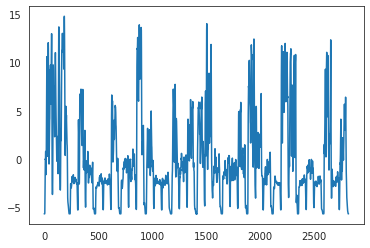

In [645]:
sim_vtc = scipy.stats.zscore(tr_df[stim_io.get_tw_collumns(tr_df, prf, shr, convolved=convolved)].to_numpy())
sim_vtc = (sim_vtc * bias[b]).sum(axis=1)

plt.plot(sim_vtc)

In [635]:
scipy.stats.zscore(np.array([[1, 2, 3],
                             [10, 11, 49]]))

array([[-1., -1., -1.],
       [ 1.,  1.,  1.]])

In [631]:
 1.04483602 + -1.29185041 +  0.60323497 + -1.1299772 +  0.77375662

2.220446049250313e-16

In [629]:
zs(tr_df[stim_io.get_tw_collumns(tr_df, prf, shr, convolved=convolved)].to_numpy())

array([[-0.66406749, -0.82367825, -0.84192507, -0.87980764, -2.46562791],
       [-0.66421744, -0.82230798, -0.84161544, -0.87825038, -2.46562791],
       [-0.66406733, -0.82395819, -0.8419918 , -0.88012567, -2.46562791],
       ...,
       [-0.66417737, -0.82262123, -0.84170199, -0.87861093, -2.46562791],
       [-0.66408811, -0.82353952, -0.84189024, -0.8796487 , -2.46562791],
       [-0.66420506, -0.82250172, -0.84165991, -0.8784709 , -2.46562791]])

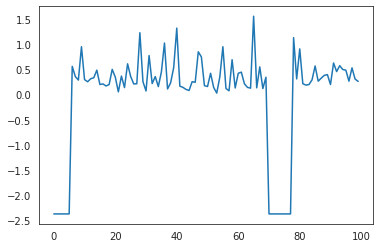

In [624]:
plt.plot(zs(tr_df['surprisal'][0:100]))

In [617]:
model_regressors
model_regressors_temp = {'base': ['raw_acti'],
                         'adaptation': ['adapt'],
                         'prediction': ['pred_prob', 'surprisal'],
                         'base_U_adaptation': ['raw_acti', 'adapt_activ'],
                         'base_U_prediction': ['raw_acti', 'pred_prob', 'surprisal'],
                         'adaptation_U_prediction': ['adapt_activ', 'pred_prob', 'surprisal'],
                         'base_U_adaptation_U_prediction': ['raw_acti',
                                                             'adapt_activ',
                                                             'pred_prob',
                                                             'surprisal']}

In [647]:
# quick settings
n_splits = 6  #6
convolved = True

# get vtc filenames and settings
runz = [1,2,3,4,5,6,7,8,9,10,11,12]
save_predict = False

# set modeltype
modeltype = LinearRegression() #can be LinearRegression (ols), Ridge(alpha=..), Lasso(alpha=..)  etc.
key_ai = ['raw_scores', 'coefs', 'intercepts', 'correlation'] # what keys to median and mean across folds

# devide over runs
run_nr = np.repeat(runz, simvoxels.shape[-1] / len(runz)).astype(np.uint8)


## --- DEFINING TEST TRAIN SPLIT ---

# get test train splits per run
train_matrix, test_matrix = train_test_splits(df, n_splits)
linidx = 0

# predefine dictionaries for saving regression results
scores = {}

## --- BASED ON TUNING PREF AND TW LOAD DESIRED COLUMNS OUT OF DF ---
for prf, shr in itertools.product(sim_prefs, sim_sharps):

    # load (all) xnames
    col_names = stim_io.get_tw_collumns(tr_df, prf, shr, convolved=convolved)
    
# --- LOAD SIMULATED VOXELS ---
    y  = simvoxels[:,linidx,:].transpose()
    linidx += 1

    
# --- LOOP OVER ALL MODELS FOR DOING SET THEORY --- 
    for model in models:

        # get X for this model 
        col_regressors = extract_sublist(col_names, model_regressors_temp[model])
        X = tr_df[col_regressors].to_numpy()
        # print(f'{model}:\n\t\t{extract_sublist(col_names, model_regressors[model])}\n')

        # (re)predefine dictionary for storing this models all folds
        nscore = {}
        
#         print(model, col_regressors)
        
### --- RUN SCRIPT TO DO KFOLDED REGRESSION, AND PARSE OUTPUT IN MEANINGFULL WAY
        # get cross validated scores based on previously defined test/train splits
        for fold in range(len(train_matrix)):
            # save indexes for text number in array
            train_idx = np.argwhere(np.in1d(run_nr, train_matrix[fold])).flatten()
            test_idx = np.argwhere(np.in1d(run_nr, test_matrix[fold])).flatten()

            # select train and test sets for fold
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # do the regression
            nscore[fold+1] = model_fit(modeltype, 
                                       X_train,
                                       X_test,
                                       y_train,
                                       y_test,
                                       save_predict=save_predict)
            
        # check if we update previous chunk or initate dict using this one
        if model not in scores:
            scores[model] = nscore
        else:
            # combine all the folds into one dictionary - aditionally append chunks
            for fold in range(len(train_matrix)):
                scores[model][fold+1] = {key : np.concatenate((scores[model][fold+1][key], 
                                                               nscore[fold+1][key])) for key in nscore[fold+1]}
                
        # store median and mean across folds
        for k in key_ai:
            cv_scores = {'median':  np.median(np.array([scores[model][fold+1][k] for 
                                                        fold in range(len(train_matrix))]), axis=0),
                         'mean':   np.nanmean(np.array([scores[model][fold+1][k] for 
                                                        fold in range(len(train_matrix))]), axis=0)}
            scores[model][k] = cv_scores
            
            
### --- DO ANOTHER REGRESSION WITHOUT CROSS VALIDATION, TO VALIDATE RESULTS
        # get non-crossvalidated scores  -- ALLEEN DE LAATSTE...
        scores[model]['non-cv'] = non_cv_fit(modeltype, 
                                                X,
                                                y,
                                                save_predict=save_predict)

In [648]:
# reshape scorings
base = scores['base']['raw_scores']['median'].reshape((18,4))
adaptation = scores['adaptation']['raw_scores']['median'].reshape((18,4))
prediction = scores['prediction']['raw_scores']['median'].reshape((18,4))
base_U_adaptation = scores['base_U_adaptation']['raw_scores']['median'].reshape((18,4))
base_U_prediction = scores['base_U_prediction']['raw_scores']['median'].reshape((18,4))
adaptation_U_prediction = scores['adaptation_U_prediction']['raw_scores']['median'].reshape((18,4))
base_U_adaptation_U_prediction = scores['base_U_adaptation_U_prediction']['raw_scores']['median'].reshape((18,4))
# base = scores['base']['non-cv']['score']
# adaptation = scores['adaptation']['non-cv']['score']
# prediction = scores['prediction']['non-cv']['score']
# base_U_adaptation = scores['base_U_adaptation']['non-cv']['score']
# base_U_prediction = scores['base_U_prediction']['non-cv']['score']
# adaptation_U_prediction = scores['adaptation_U_prediction']['non-cv']['score']
# base_U_adaptation_U_prediction = scores['base_U_adaptation_U_prediction']['non-cv']['score']

linidx = 0 
for prf, shr in itertools.product(sim_prefs, sim_sharps):
    print(f'\n\n\nRegression for voxels \n-Tuned to: {2**prf:.2f}Hz, \n-Tuning width: {shr:.2f}\n')
    print('\t\tBase\tAdapt\tPred\tBase_U_Adapt\tBase_U_pred\tAdapt_U_Pred\tBase_U_Adapt_U_Pred')
    
    pr_biases = ['Adapt Voxel', 'Expect Voxel', 'Avarge Voxel', 'Sensory Voxel']
    for b in range(4):
        print(f'{pr_biases[b]}\t'
              f'{base[linidx, b]:.2f}\t'
              f'{adaptation[linidx, b]:.2f}\t'
              f'{prediction[linidx, b]:.2f}\t'
              f'{base_U_adaptation[linidx, b]:.2f}\t\t'
              f'{base_U_prediction[linidx, b]:.2f}\t\t'
              f'{adaptation_U_prediction[linidx, b]:.2f}\t\t'
              f'{base_U_adaptation_U_prediction[linidx, b]:.2f}')
    
    linidx += 1
    
    
    




Regression for voxels 
-Tuned to: 200.01Hz, 
-Tuning width: 1.05

		Base	Adapt	Pred	Base_U_Adapt	Base_U_pred	Adapt_U_Pred	Base_U_Adapt_U_Pred
Adapt Voxel	0.87	0.87	0.25	0.87		0.87		0.86		0.87
Expect Voxel	0.32	0.32	0.56	0.40		0.59		0.60		0.68
Avarge Voxel	0.79	0.78	0.44	0.80		0.82		0.83		0.84
Sensory Voxel	0.86	0.86	0.24	0.86		0.87		0.86		0.86



Regression for voxels 
-Tuned to: 200.01Hz, 
-Tuning width: 0.81

		Base	Adapt	Pred	Base_U_Adapt	Base_U_pred	Adapt_U_Pred	Base_U_Adapt_U_Pred
Adapt Voxel	0.86	0.87	0.29	0.86		0.86		0.86		0.86
Expect Voxel	0.29	0.28	0.57	0.35		0.57		0.57		0.62
Avarge Voxel	0.78	0.78	0.48	0.78		0.82		0.83		0.83
Sensory Voxel	0.86	0.85	0.30	0.86		0.86		0.86		0.86



Regression for voxels 
-Tuned to: 200.01Hz, 
-Tuning width: 0.38

		Base	Adapt	Pred	Base_U_Adapt	Base_U_pred	Adapt_U_Pred	Base_U_Adapt_U_Pred
Adapt Voxel	0.84	0.86	0.30	0.84		0.84		0.84		0.84
Expect Voxel	0.24	0.24	0.57	0.26		0.57		0.57		0.57
Avarge Voxel	0.75	0.76	0.50	0.75		0.81		0.81		0.81
Senso

In [494]:
scores['base']['raw_scores']['median'].reshape((18,4))

array([[0.35818445, 0.22167394, 0.22466307, 0.9630021 ],
       [0.21329789, 0.13260559, 0.1318589 , 0.96384323],
       [0.04043342, 0.03848111, 0.0337133 , 0.95538686],
       [0.59291214, 0.37902367, 0.40677245, 0.96081648],
       [0.50574957, 0.26321437, 0.2848848 , 0.96350821],
       [0.25027649, 0.09490042, 0.1104093 , 0.96438993],
       [0.79148453, 0.64752078, 0.67243835, 0.96221272],
       [0.72298802, 0.53872887, 0.57724378, 0.96476175],
       [0.55563182, 0.32922401, 0.36532213, 0.96133955],
       [0.90557972, 0.86014999, 0.87415392, 0.9616016 ],
       [0.86184615, 0.773479  , 0.80572406, 0.96183278],
       [0.63761012, 0.45747106, 0.48409192, 0.9616483 ],
       [0.83721521, 0.72581803, 0.75231887, 0.96227093],
       [0.77203971, 0.61325963, 0.64533414, 0.96207268],
       [0.58248802, 0.38991065, 0.42040381, 0.95830777],
       [0.65515035, 0.45258738, 0.47961576, 0.95839998],
       [0.56205582, 0.33866375, 0.35614283, 0.95668624],
       [0.35782884, 0.1518296 ,

In [493]:
scores['base']['raw_scores']['median'].reshape((18,4))

array([[0.35818445, 0.22167394, 0.22466307, 0.9630021 ],
       [0.21329789, 0.13260559, 0.1318589 , 0.96384323],
       [0.04043342, 0.03848111, 0.0337133 , 0.95538686],
       [0.59291214, 0.37902367, 0.40677245, 0.96081648],
       [0.50574957, 0.26321437, 0.2848848 , 0.96350821],
       [0.25027649, 0.09490042, 0.1104093 , 0.96438993],
       [0.79148453, 0.64752078, 0.67243835, 0.96221272],
       [0.72298802, 0.53872887, 0.57724378, 0.96476175],
       [0.55563182, 0.32922401, 0.36532213, 0.96133955],
       [0.90557972, 0.86014999, 0.87415392, 0.9616016 ],
       [0.86184615, 0.773479  , 0.80572406, 0.96183278],
       [0.63761012, 0.45747106, 0.48409192, 0.9616483 ],
       [0.83721521, 0.72581803, 0.75231887, 0.96227093],
       [0.77203971, 0.61325963, 0.64533414, 0.96207268],
       [0.58248802, 0.38991065, 0.42040381, 0.95830777],
       [0.65515035, 0.45258738, 0.47961576, 0.95839998],
       [0.56205582, 0.33866375, 0.35614283, 0.95668624],
       [0.35782884, 0.1518296 ,

In [436]:
 np.random.normal(0,0.2,len(sim_vtc))

array([0.12718462, 0.24312558, 0.26314824, ..., 0.28422194, 0.00649608,
       0.12978936])

In [370]:
scores.keys()

dict_keys(['base', 'adaptation', 'prediction', 'base_U_adaptation', 'base_U_prediction', 'adaptation_U_prediction', 'base_U_adaptation_U_prediction'])

In [373]:
scores['base_U_adaptation_U_prediction']['raw_scores']

{'median': array([-0.74704195, -1.52179303, -0.26700139, ..., -0.33969343,
        -0.45730731, -0.0618167 ]),
 'mean': array([-1.39893686, -1.8958335 , -1.08478259, ..., -0.4058992 ,
        -0.4014978 , -0.11971232])}

In [374]:
scores['base']['raw_scores']

{'median': array([-0.68227388, -1.46002852, -0.19784024, ..., -0.3355125 ,
        -0.40793156, -0.04582567]),
 'mean': array([-1.35385195, -1.87039668, -1.07224585, ..., -0.39511273,
        -0.37980064, -0.10720893])}

In [169]:
# NEW METHOD - load all runs of chuck

# set chucking size
chucksize = 50000 #msk[0].shape[0]
chucktoanalyse = 0

# pp settings
nr_runs = 12
pp = 2
ses = 2

# load only header information
head, _ = vtc.read_vtc_msk(fullpath, tuple((np.array([0]),
                                            np.array([0]),
                                            np.array([0]))))

# get expected vtc dim
vtcdim = vtc.get_vtc_dims(head)

# load full mask and convert to indeces
_, msk = bvbabel.msk.read_msk(mskpath)
msk = np.where(msk)

# devide the mask in chucks based on our chucksize
chucked_msk = vtc.chuck_msk(msk, chucksize)

# to loop over all chucks we can do
#for chuck in chucked_msk: # remove this - just for testing speed
chuck = chucked_msk[chucktoanalyse]

# predefine full image over runs
# y = np.zeros((msk[0].shape[0], vtcdim[-1], nr_runs))
y = np.zeros((chuck[0].shape[0], vtcdim[-1], nr_runs))
run_nr = np.zeros((vtcdim[-1], nr_runs))

for run in np.arange(0,nr_runs):
    # get current runpath
    fullpath = join(mridat_dir, pp_dir(pp,ses), fn(pp,ses,run+1))

    # mask the vtc
    _, y[:,:,run] = vtc.read_vtc_msk(fullpath, chuck)
    run_nr[:, run] = run + 1

# reshape into single dim
run_nr = run_nr.reshape((-1),order='F')
y = y.reshape((y.shape[0], -1), order='F').transpose()

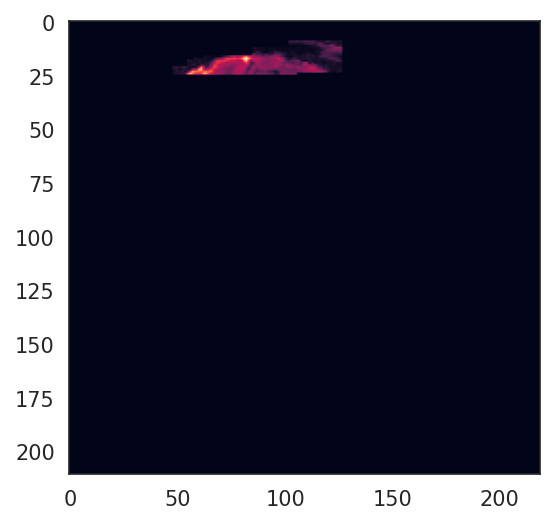

In [171]:
# preprecreat a empty image with the dimension
#  of the full vtc - for plotting purpuses
rec_img = np.zeros(vtc.get_vtc_dims(head))
    
# fill in chuck in reconstructed image
rec_img[chuck] = y[run_nr == 5].transpose()
    
# finaly show the full picture
plt.imshow(rec_img[:,:,20,100])

In [31]:
# TESTING WITHOUT CV, ONE RUN

n_splits = 6  #6
tpref = 9.9228
tw = 0.896
convolved = True

modeltype = LinearRegression() #can be LinearRegression (ols), Ridge(alpha=..), Lasso(alpha=..)  etc.

# get test train splits per run
train_matrix, test_matrix = train_test_splits(df, n_splits)

# load xnames
col_names = stim_io.get_tw_collumns(tr_df, tpref, tw, convolved=convolved)
X = tr_df[col_names].to_numpy()


tic = time.time()

model = LinearRegression()
model.fit(X, y)

print(f'Fitting time {time.time()-tic}')



Fitting time 256.9649393558502


In [33]:
model.coef_[:].shape

(1030491, 5)

In [116]:
# mini batch
y = y[:, :100000]

n_splits = 6  #6
tpref = 9.9228
tw = 0.896
convolved = True

modeltype = LinearRegression() #can be LinearRegression (ols), Ridge(alpha=..), Lasso(alpha=..)  etc.

# get test train splits per run
train_matrix, test_matrix = train_test_splits(df, n_splits)

# load xnames
col_names = stim_io.get_tw_collumns(tr_df, tpref, tw, convolved=convolved)
X = tr_df[col_names].to_numpy()

# get cross validated scores based on previously defined test/train splits
for fold in range(len(train_matrix)):
    # save indexes for text number in array
    train_idx = np.argwhere(np.in1d(run_nr, train_matrix[fold])).flatten()
    test_idx = np.argwhere(np.in1d(run_nr, test_matrix[fold])).flatten()
    
    # select train and test sets for fold
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # fit models
    scores = model_fit(modeltype, 
                   X_train,
                   X_test,
                   y_train,
                   y_test,
                   save_predict=True)


NameError: name 'corr_column' is not defined

In [ ]:
scores

In [66]:
corr_column= lambda a,b: (zs(a)*zs(b)).mean(0)
zs=lambda x: (x-x.mean(0)) /x.std(0)

tic = time.time()

scores = model_fit(modeltype, 
                   X_train,
                   X_test,
                   y_train,
                   y_test,
                   save_predict=True)

print(time.time() - tic)

/tmp/ipykernel_659278/2323394684.py:2: RuntimeWarning: invalid value encountered in divide
  zs=lambda x: (x-x.mean(0)) /x.std(0)


10.229035139083862


In [65]:
scores['correlation'].shape

(100000,)

In [63]:
scores

{'score': -7.235004132978681,
 'coefs': array([[ 4.89258629e-01, -1.18898572e+01,  7.56870327e-01,
          2.57455629e+01, -4.60913638e-01],
        [-1.99041657e-01, -2.30454465e+01,  1.20322865e+01,
          4.15728712e+01, -7.09975534e-01],
        [-2.99820394e-01, -1.55549290e+01,  7.37679068e+00,
          2.67186109e+01, -4.04082378e-01],
        ...,
        [-3.10693471e-02,  8.67504054e-01,  2.40494973e-01,
         -1.83384141e+00,  1.55237808e-02],
        [-8.73615539e-01, -5.25914140e+00,  7.14076623e+00,
          6.74926536e+00, -1.13767520e-01],
        [-3.83067845e-01, -4.57891448e+00,  8.56986971e+00,
          2.85643300e+00, -2.69626664e-02]]),
 'intercepts': array([509.48357276, 496.52179131, 459.45129908, ..., 654.88130775,
        588.50909221, 549.02854209]),
 'correlation': array([-0.03666512, -0.06389173,  0.00365483, ...,  0.01175025,
        -0.06033181,  0.12623145]),
 'predict': {'y_pred': array([[509.47975067, 496.51942654, 459.44808997, ..., 654.881

In [63]:
# Code source: Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
X, y = datasets.load_diabetes(return_X_y=True)

# artifically make longer
X = np.repeat(X, 1000, axis=0)
y = np.repeat(y, 1000)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
st_time = time.time()
regr.fit(X, y)
en_time = time.time()

# Make predictions using the testing set
y_pred = regr.predict(X) # on same

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y, y_pred))

print(f"\n\nTime elepsed: {en_time - st_time}")

Coefficients: 
 [ -10.0098663  -239.81564367  519.84592005  324.3846455  -792.17563855
  476.73902101  101.04326794  177.06323767  751.27369956   67.62669218]
Mean squared error: 2859.70
Coefficient of determination: 0.52


Time elepsed: 0.19521355628967285


## test with multi output regression

In [125]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
X, y = datasets.load_diabetes(return_X_y=True)

# artifically make longer
X = np.repeat(X, 10, axis=0)
y = np.repeat(y, 10)

# add muli output
nr_outputs = 10000
y_array = np.empty((len(y),nr_outputs))
for i in range(nr_outputs):
    noise = np.random.normal(0,1,len(y))
    y_array[:,i] = (y + i) + noise

In [126]:
print(f"X_shape: {X.shape}, y_shape: {y_array.shape}")

X_shape: (4420, 10), y_shape: (4420, 10000)


In [130]:
# Create linear regression object
regr = linear_model.LinearRegression()
#regr = linear_model.Ridge()

# Train the model using the training sets
st_time = time.time()
regr.fit(X, y_array)

# Make predictions using the testing set
y_pred = regr.predict(X) # on same

en_time = time.time()

# The coefficients
print("Coefficients: \n", regr.coef_[:5,:])
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_array, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_array, y_pred))

print(f"\n\nTime elepsed: {en_time - st_time}")

Coefficients: 
 [[ -10.48807724 -239.97856789  520.84343681  324.4613845  -791.58240456
   476.2713538   102.16750765  177.23108136  751.27883114   67.56355894]
 [ -10.0097399  -239.842739    519.78837864  324.09269098 -797.83528075
   481.52281114  103.13077099  176.78086994  753.61001469   67.27487198]
 [  -9.64989898 -240.25468433  519.87125835  324.23552587 -789.62883108
   475.86979662   98.90859862  174.97349245  750.75452479   67.5878756 ]
 [ -10.44954849 -240.2784099   520.22070085  324.00588371 -794.68064613
   479.063763    101.8070797   176.57873227  752.56249629   67.74768672]
 [  -9.50164313 -240.01072707  520.01141489  324.56763096 -796.91501245
   480.06209254  102.75707686  177.30429837  752.90943943   67.47374245]]
Mean squared error: 2860.66
Coefficient of determination: 0.52


Time elepsed: 1.3165748119354248


### Naive approach, looping

In [110]:
# predefine y_ped to fill in later
y_pred = np.empty(y_array.shape)
coefs = np.empty((y_array.shape[1], X.shape[1]))

# Create linear regression object
regr = linear_model.LinearRegression()

regdict = {}
# Train the model using the training sets
st_time = time.time()
for i in range(y_array.shape[1]):
    regr.fit(X, y_array[:,i])
    y_pred[:,i] = regr.predict(X)
    coefs[i,:] = regr.coef_
en_time = time.time()

# The coefficients
print("Coefficients: \n", coefs[:5,:])
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_array, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_array, y_pred))

print(f"\n\nTime elepsed: {en_time - st_time}")

Coefficients: 
 [[ -10.16487504 -239.86449769  520.56799945  324.74679347 -789.62206839
   474.33197278  100.26550138  177.16111041  750.34023343   66.97250222]
 [ -10.24633619 -239.51653201  520.25314523  325.18413251 -793.2565245
   478.19771359  100.28095438  175.21619054  751.86151005   67.56743131]
 [  -9.7079165  -240.34233855  519.79535254  323.66512088 -789.14400953
   473.49771868   99.69761002  178.21222642  749.39892867   68.29695671]
 [ -10.30041395 -240.102431    520.45294895  324.21224795 -793.63005415
   478.35746778  101.81786668  176.97796479  752.14788448   67.43570795]
 [ -10.10405988 -239.60578626  519.2277324   325.08961294 -795.63239282
   479.36184881  103.28731299  178.14857921  752.08302328   67.73754644]]
Mean squared error: 2860.70
Coefficient of determination: 0.52


Time elepsed: 27.34202527999878


### using multioutput extention

In [119]:
from sklearn.multioutput import MultiOutputRegressor

# Create linear regression object
regr = MultiOutputRegressor(linear_model.LinearRegression())

# Train the model using the training sets
st_time = time.time()
regr.fit(X, y_array)

# Make predictions using the testing set
y_pred = regr.predict(X) # on same

en_time = time.time()

# The coefficients
print("Coefficients: \n", regr.coef_[:5,:])
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_array, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_array, y_pred))

print(f"\n\nTime elepsed: {en_time - st_time}")

AttributeError: 'MultiOutputRegressor' object has no attribute 'coef_'

In [120]:
print(f"\n\nTime elepsed: {en_time - st_time}")



Time elepsed: 194.10489463806152


In [121]:
regr.coef_

AttributeError: 'MultiOutputRegressor' object has no attribute 'coef_'